# Advanced Econometrics (JEM217) – Empirical Project (WS 2025)

- **Title:      Determinants of Lap Times in Formula 1**
- **Authors:    Sebastian Pasz \& Vojtěch Dohnal**

**AI Usage**

ChatGPT-5 was used during the preparation of this assignment **solely for grammatical editing and minor code optimization**.  
Any sections where AI-assisted code optimization was applied are explicitly indicated within the notebook.

## Initial Preparation

In this section, we install and load all required R packages necessary for data simulation, estimation, and visualization.

In [126]:
req_pkgs <- c("ggplot2","dplyr","quantreg","lmtest","sandwich","car","stargazer","knitr","glm2","gmm","msm","plm","modelsummary","readxl","lubridate","stringr","corrplot","Amelia","visdat","gridExtra","xtable")
for (p in req_pkgs) {
  if (!requireNamespace(p, quietly = TRUE)) {
    install.packages(p, repos = "https://cloud.r-project.org")
  }
}
library(ggplot2)
library(dplyr)
library(quantreg)
library(lmtest)
library(sandwich)
library(car)
library(stargazer)
library(knitr)
library(glm2)
library(gmm)
library(msm)
library(plm)
library(modelsummary)
library(readxl)
library(lubridate)
library(stringr)
library(corrplot)
library(Amelia)
library(visdat)
library(gridExtra)
library(xtable)

Warning message:
"package 'xtable' was built under R version 4.4.3"


In [47]:
data <- read_excel("./Dataset_2025.xlsx")

print(sum(!complete.cases(data[, c("Driver", "LapTime", "LapNumber", "Compound", "TyreLife", 
                             "Team", "TrackStatus", "Position", "AirTemp", 
                             "Humidity", "Pressure", "Rainfall", "TrackTemp", "WindSpeed")])))

str(data)

[1] 927
tibble [29,145 × 41] (S3: tbl_df/tbl/data.frame)
 $ year              : num [1:29145] 2025 2025 2025 2025 2025 ...
 $ country           : chr [1:29145] "Abu Dhabi" "Abu Dhabi" "Abu Dhabi" "Abu Dhabi" ...
 $ session           : chr [1:29145] "Race" "Race" "Race" "Race" ...
 $ Time              : num [1:29145] 0.0416 0.0416 0.0416 0.0416 0.0416 ...
 $ Driver            : chr [1:29145] "VER" "PIA" "NOR" "LEC" ...
 $ DriverNumber      : chr [1:29145] "1" "81" "4" "16" ...
 $ LapTime           : num [1:29145] 0.00106 0.00108 0.00109 0.0011 0.0011 ...
 $ LapNumber         : num [1:29145] 1 1 1 1 1 1 1 1 1 1 ...
 $ Stint             : num [1:29145] 1 1 1 1 1 1 1 1 1 1 ...
 $ PitOutTime        : num [1:29145] NA NA NA NA NA NA NA NA NA NA ...
 $ PitInTime         : num [1:29145] NA NA NA NA NA NA NA NA NA NA ...
 $ Sector1Time       : num [1:29145] NA NA NA NA NA NA NA NA NA NA ...
 $ Sector2Time       : num [1:29145] 0.000445 0.000444 0.000448 0.00045 0.000447 ...
 $ Sector3Time      

In [48]:

# Count how many races is in the dataset
num_unique_races <- data %>%
  distinct(year, country) %>%
  nrow()

print(num_unique_races)

data <- data[, colSums(!is.na(data)) > 0]


[1] 24


In [49]:
# Clean and convert TrackStatus
data <- data %>%
  mutate(TrackStatus = as.character(TrackStatus))

# Create dummy variables
for (status_code in 1:7) {
  varname <- paste0("TrackStatus_", status_code)
  data[[varname]] <- ifelse(str_detect(data$TrackStatus, as.character(status_code)), 1, 0)
}

data <- data %>% select(-TrackStatus_1, -TrackStatus_3, -TrackStatus_7)

data <- data %>%
  mutate(Rainfall = ifelse(Rainfall == TRUE, 1, 0))
# Convert LapTime and sector times to numeric seconds
data <- data %>%
  mutate(
    Time = Time * 86400,
    LapTime = LapTime * 86400,
    PitOutTime = PitOutTime * 86400,
    PitInTime = PitInTime * 86400,
    Sector1Time = Sector1Time * 86400,
    Sector2Time = Sector2Time * 86400,
    Sector3Time = Sector3Time * 86400,
    LapStartTime = LapStartTime * 86400
  )


data <- data %>%
  mutate(
    PitInTime = as.numeric(PitInTime),
    PitOutTime = as.numeric(PitOutTime)
  )

# Replace NA with 0 safely
data <- data %>%
  mutate(
    PitInTime = ifelse(is.na(PitInTime), 0, PitInTime),
    PitOutTime = ifelse(is.na(PitOutTime), 0, PitOutTime),
    InPit = ifelse(!is.na(PitInTime) & PitInTime > 0, 1, 0),
    OutPit = ifelse(!is.na(PitOutTime) & PitOutTime > 0, 1, 0)
  )

In [ ]:
#Lag creation - based of Litrev
data <- data %>%
  mutate(LapNumber = as.numeric(LapNumber)) %>%
  mutate(RaceID = paste0(country, year, session)) %>%
  arrange(Driver, RaceID, LapNumber) %>%
  group_by(Driver, RaceID) %>%
  mutate(
    row_id = row_number(),  # helper index
    TrackStatus_2_lag1 = TrackStatus_2[match(row_id - 1, row_id)],
    TrackStatus_2_lag2 = TrackStatus_2[match(row_id - 2, row_id)],
    
    TrackStatus_4_lag1 = TrackStatus_4[match(row_id - 1, row_id)],
    TrackStatus_4_lag2 = TrackStatus_4[match(row_id - 2, row_id)],
    
    TrackStatus_5_lag1 = TrackStatus_5[match(row_id - 1, row_id)],
    TrackStatus_5_lag2 = TrackStatus_5[match(row_id - 2, row_id)],
    TrackStatus_5_lag3 = TrackStatus_5[match(row_id - 3, row_id)],
    
    TrackStatus_6_lag1 = TrackStatus_6[match(row_id - 1, row_id)],
    TrackStatus_6_lag2 = TrackStatus_6[match(row_id - 2, row_id)],
    
    OutPit_lag1 = OutPit[match(row_id - 1, row_id)]
  ) %>%
  select(-row_id) %>%
  ungroup()

cols_to_fill <- c(
  "TrackStatus_2_lag1","TrackStatus_2_lag2","TrackStatus_4_lag1","TrackStatus_4_lag2",
  "TrackStatus_5_lag1","TrackStatus_5_lag2","TrackStatus_5_lag3",
  "TrackStatus_6_lag1","TrackStatus_6_lag2","OutPit_lag1"
)

data <- data %>%
  mutate(across(all_of(cols_to_fill), ~ ifelse(is.na(.), 0, .)))

unique(data$Compound)
data <- data %>%
  filter(!(Compound %in% c("UNKNOWN", "nan"))) %>%
  mutate(Compound = droplevels(as.factor(Compound)))
unique(data$Compound)

[1] "SOFT"         "HARD"         "MEDIUM"       "INTERMEDIATE" "nan"

[1] SOFT         HARD         MEDIUM       INTERMEDIATE
Levels: HARD INTERMEDIATE MEDIUM SOFT

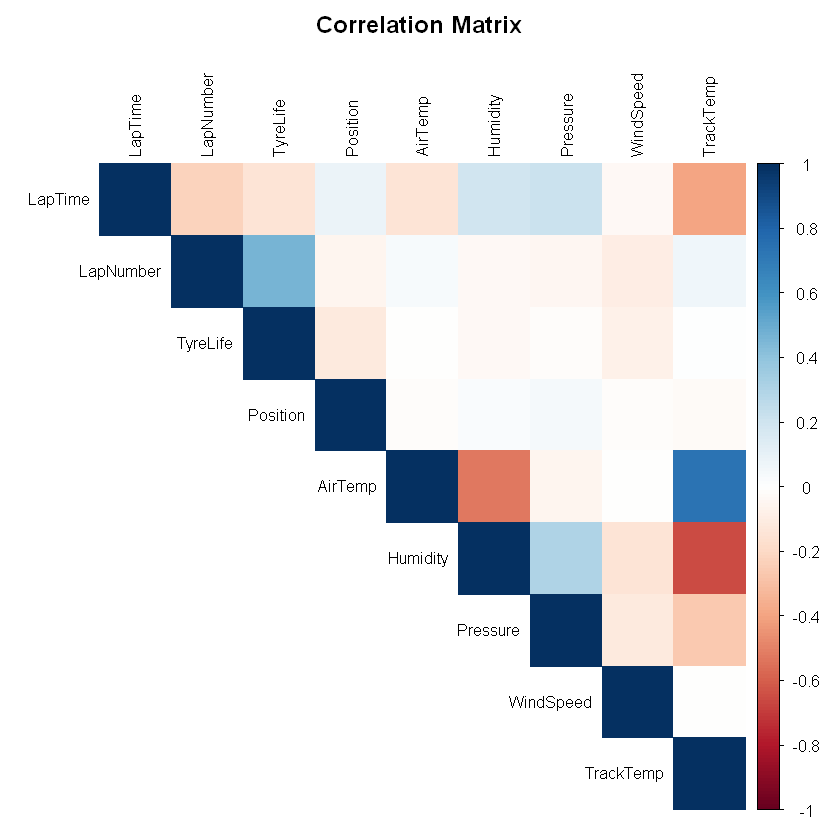

In [51]:
# variance covariance matrix
vars <- c("LapTime", "LapNumber", "TyreLife", "Position", 
          "AirTemp", "Humidity", "Pressure", "WindSpeed", "TrackTemp")

# Remove rows with NAs
data <- data[complete.cases(data[ , vars]), ]
# Compute covariance matrix
cov_matrix <- cov(data[ , vars])

cor_matrix <- cov2cor(cov_matrix)
par(bg = "white")
#  plot data#  plot 
corrplot(cor_matrix, method = "color", type = "upper", 
         tl.col = "black", tl.cex = 0.8, title = "Correlation Matrix", 
         mar = c(0,0,2,0))



In [53]:
colnames(data)

[1] "year"               "country"            "session"           
 [4] "Time"               "Driver"             "DriverNumber"      
 [7] "LapTime"            "LapNumber"          "Stint"             
[10] "PitOutTime"         "PitInTime"          "Sector1Time"       
[13] "Sector2Time"        "Sector3Time"        "Sector1SessionTime"
[16] "Sector2SessionTime" "Sector3SessionTime" "SpeedI1"           
[19] "SpeedI2"            "SpeedFL"            "SpeedST"           
[22] "IsPersonalBest"     "Compound"           "TyreLife"          
[25] "FreshTyre"          "Team"               "LapStartTime"      
[28] "TrackStatus"        "Position"           "FastF1Generated"   
[31] "IsAccurate"         "AirTemp"            "Humidity"          
[34] "Pressure"           "Rainfall"           "TrackTemp"         
[37] "WindDirection"      "WindSpeed"          "TrackStatus_2"     
[40] "TrackStatus_4"      "TrackStatus_5"      "TrackStatus_6"     
[43] "InPit"              "OutPit"             "RaceID"            
[46] "TrackStatus_2_lag1" "TrackStatus_2_lag2" "TrackStatus_4_lag1"
[49] "TrackStatus_4_lag2" "TrackStatus_5_lag1" "TrackStatus_5_lag2"
[52] "TrackStatus_5_lag3" "TrackStatus_6_lag1" "TrackStatus_6_lag2"
[55] "OutPit_lag1"

In [54]:
head(data)
data <- data %>%
  select(-Time, -DriverNumber,
         -Sector1SessionTime, -Sector2SessionTime, -Sector3SessionTime,
         -SpeedFL, -LapStartTime,
         -TrackStatus, -Sector1Time, -Sector2Time, -Sector3Time,
         -PitOutTime, -PitInTime,
         -IsPersonalBest, -FastF1Generated, -IsAccurate,
         -WindDirection, -year, -SpeedI1, -SpeedI2, -SpeedST, -FreshTyre, -WindSpeed)
colnames(data)

year,country,session,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,⋯,TrackStatus_2_lag1,TrackStatus_2_lag2,TrackStatus_4_lag1,TrackStatus_4_lag2,TrackStatus_5_lag1,TrackStatus_5_lag2,TrackStatus_5_lag3,TrackStatus_6_lag1,TrackStatus_6_lag2,OutPit_lag1
<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2025,Abu Dhabi,Race,3600.491,ALB,23,99.757,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,3692.201,ALB,23,91.710,2,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,3782.425,ALB,23,90.224,3,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,3873.299,ALB,23,90.874,4,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,3963.613,ALB,23,90.314,5,1,0,⋯,0,0,0,0,0,0,0,0,0,0
2025,Abu Dhabi,Race,4053.836,ALB,23,90.223,6,1,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] "country"            "session"            "Driver"            
 [4] "LapTime"            "LapNumber"          "Stint"             
 [7] "Compound"           "TyreLife"           "Team"              
[10] "Position"           "AirTemp"            "Humidity"          
[13] "Pressure"           "Rainfall"           "TrackTemp"         
[16] "TrackStatus_2"      "TrackStatus_4"      "TrackStatus_5"     
[19] "TrackStatus_6"      "InPit"              "OutPit"            
[22] "RaceID"             "TrackStatus_2_lag1" "TrackStatus_2_lag2"
[25] "TrackStatus_4_lag1" "TrackStatus_4_lag2" "TrackStatus_5_lag1"
[28] "TrackStatus_5_lag2" "TrackStatus_5_lag3" "TrackStatus_6_lag1"
[31] "TrackStatus_6_lag2" "OutPit_lag1"

Warning message:
"Unknown or uninitialised column: `arguments`."
Warning message:
"Unknown or uninitialised column: `arguments`."
Warning message:
"Unknown or uninitialised column: `imputations`."


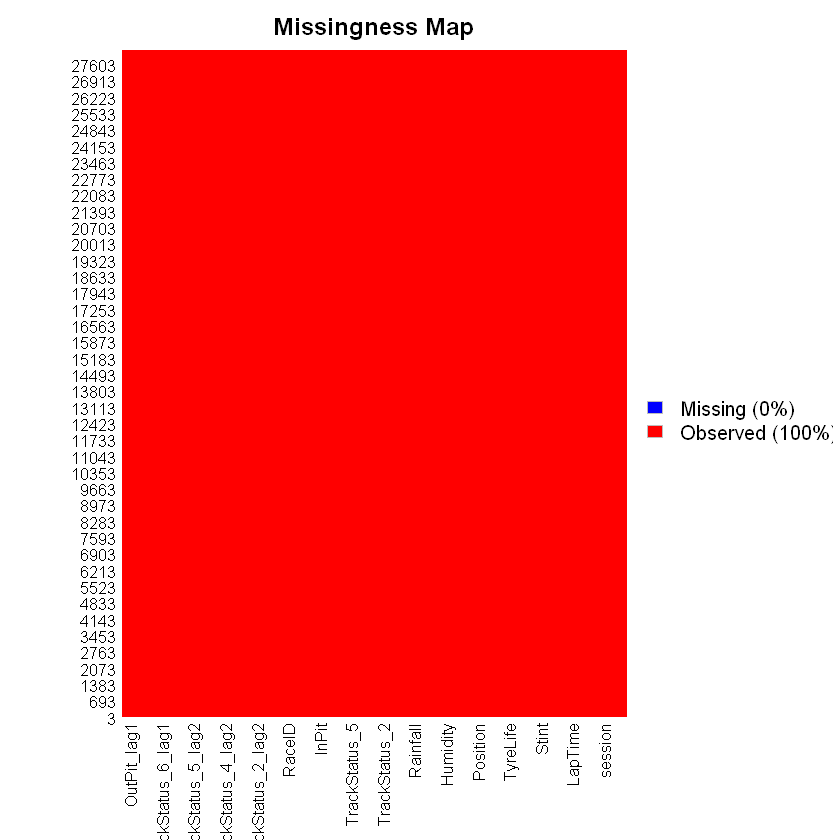

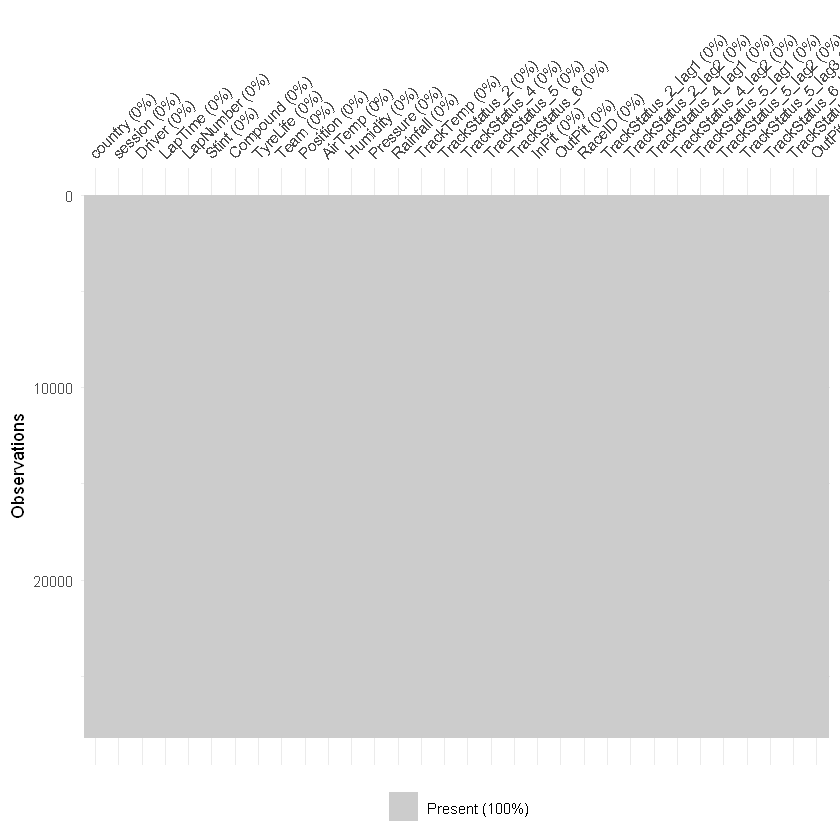

In [55]:
par(bg = "white")
missmap(data, col = c("blue", "red"))

vis_miss(data, warn_large_data = F)

In [65]:
# Dealing with outliers
grouped_outliers <- data %>%
  group_by(Driver, country, session) %>%  # Change if other grouping is needed
  mutate(
    Q1 = quantile(LapTime, 0.25, na.rm = TRUE),
    Q3 = quantile(LapTime, 0.75, na.rm = TRUE),
    IQR = Q3 - Q1,
    lower_bound = Q1 - 1.5 * IQR,
    upper_bound = Q3 + 1.5 * IQR,
    is_outlier = LapTime < lower_bound | LapTime > upper_bound
  )


Q1 = quantile(data$LapTime, 0.25, na.rm = TRUE)
Q3 = quantile(data$LapTime, 0.75, na.rm = TRUE)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count total number of outliers
outlier_count <- sum(grouped_outliers$is_outlier, na.rm = TRUE)
cat("Total number of outliers in LapTime:", outlier_count, "\n")

Total number of outliers in LapTime: 2969 


In [ ]:
# Filter Outliers
data <- data %>%
  group_by(Driver,country, session) %>%
  filter(!is.na(LapTime)) %>%
  mutate(
    Q1 = quantile(LapTime, 0.25, na.rm = TRUE),
    Q3 = quantile(LapTime, 0.75, na.rm = TRUE),
    IQR = Q3 - Q1,
    lower_bound = Q1 - 1.5 * IQR,
    upper_bound = Q3 + 1.5 * IQR
  ) %>%
  filter(
    (LapTime >= lower_bound & LapTime <= upper_bound & TrackStatus_2 == 0 & TrackStatus_4 == 0 & TrackStatus_5 == 0 & TrackStatus_6 == 0)
  ) %>%
  select(-Q1, -Q3, -IQR, -lower_bound, -upper_bound)

data <- data %>%
  arrange(Driver, country, session, LapNumber) %>%
  group_by(Driver, country, session)

nrow(data)

Warning message in split.default(plots, rep(1:length(grid_layout), times = grid_layout)):
"data length is not a multiple of split variable"


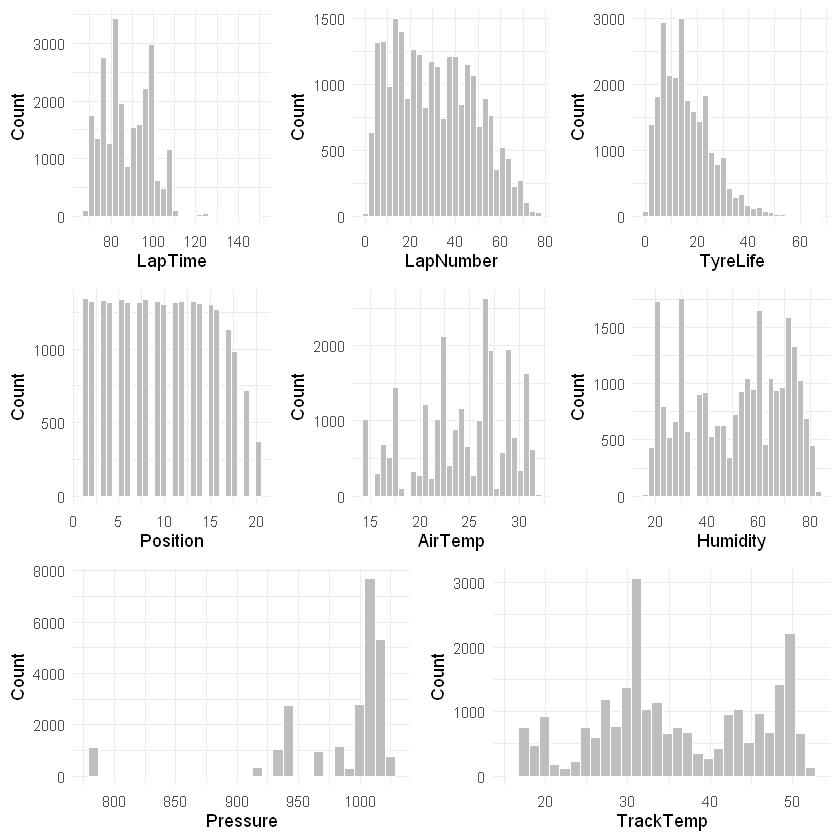

In [79]:
numeric_cols <- c(
  "LapTime", "LapNumber", "TyreLife", "Position", "AirTemp", "Humidity", "Pressure",
  "TrackTemp"
)

# Create list of ggplot histogram objects
plots <- lapply(numeric_cols, function(col_name) {
  ggplot(data, aes_string(x = col_name)) +
    geom_histogram(bins = 30, fill = "grey", color = "white") +
    theme_minimal() +
    labs( x = col_name, y = "Count")
})

# Arrange the plots into a grid (3 per row, last row has 2)
grid_layout <- c(rep(3, 3))  # Defines how many per row

# Split into groups of up to 3
split_plots <- split(plots, rep(1:length(grid_layout), times = grid_layout))

# Draw all rows sequentially
grid_rows <- lapply(split_plots, function(row_plots) {
  do.call(gridExtra::arrangeGrob, c(row_plots, nrow = 1))
})

# Combine all rows into one page and plot
final_plot <- do.call(gridExtra::grid.arrange, c(grid_rows, ncol = 1))

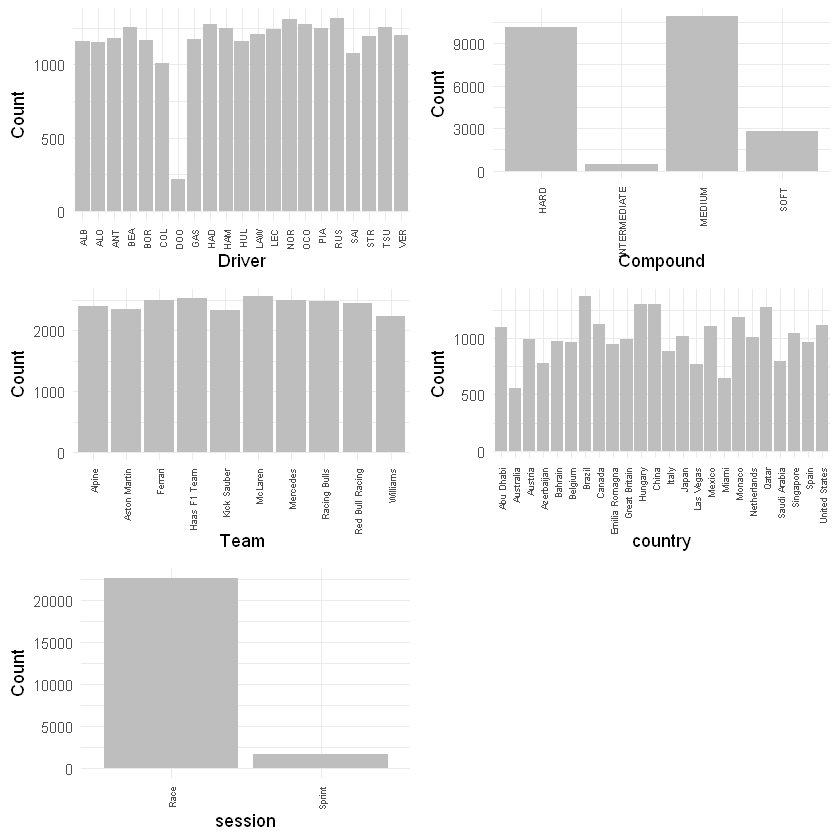

In [84]:
# Define factor variables to plot
factor_vars <- c("Driver", "Compound", "Team", "country", "session")

# Create individual plots for each factor variable
plots <- lapply(factor_vars, function(var) {
  ggplot(data, aes_string(x = var)) +
    geom_bar(fill = "grey") +
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 5.3)
    ) +
    labs( x = var, y = "Count")
})
# Arrange plots in a 3x2 grid
grid.arrange(grobs = plots, ncol = 2, nrow = 3)


In [121]:
pdata2 <- data
data <- data %>%
  mutate(
    Compound = as.factor(Compound),
    SessionType = as.factor(session),
    Country = as.factor(country),
    Driver = as.factor(Driver),
    Team = as.factor(Team)
  )


data$RaceID <- paste(data$country, data$session, sep = "_")
data <- data %>%
  mutate(
    LapNumber = as.integer(LapNumber),
    RaceID = as.factor(RaceID),
    Driver = as.factor(Driver)
  )
data <- data %>%
  arrange(Driver, country, session, LapNumber) %>%
  group_by(Driver, country, session)

  cols <- c("LapTime","TyreLife","AirTemp","TrackTemp","Humidity","Pressure","Rainfall", 
           "InPit", "OutPit")
options(scipen = 999)
# Create a summary data frame
summary_stats <- data.frame(
  Variable = cols,
  Mean = sapply(data[cols], mean, na.rm = TRUE ),
  Median = sapply(data[cols], median, na.rm = TRUE ),
  SD = sapply(data[cols], sd, na.rm = TRUE) 
)

# Print the summary
print(summary_stats)


           Variable          Mean   Median          SD
LapTime     LapTime  87.356587949   85.267 10.88896511
TyreLife   TyreLife  15.811004489   14.000  9.67871801
AirTemp     AirTemp  24.207199045   24.800  4.69074416
TrackTemp TrackTemp  35.745051687   33.900  9.77131335
Humidity   Humidity  51.043696718   55.000 18.96750086
Pressure   Pressure 984.495692105 1007.200 52.95088472
Rainfall   Rainfall   0.008278078    0.000  0.09060844
InPit         InPit   0.007536757    0.000  0.08648851
OutPit       OutPit   0.002882913    0.000  0.05361641


In [132]:
colnames(data)

[1] "country"            "session"            "Driver"            
 [4] "LapTime"            "LapNumber"          "Stint"             
 [7] "Compound"           "TyreLife"           "Team"              
[10] "Position"           "AirTemp"            "Humidity"          
[13] "Pressure"           "Rainfall"           "TrackTemp"         
[16] "TrackStatus_2"      "TrackStatus_4"      "TrackStatus_5"     
[19] "TrackStatus_6"      "InPit"              "OutPit"            
[22] "RaceID"             "TrackStatus_2_lag1" "TrackStatus_2_lag2"
[25] "TrackStatus_4_lag1" "TrackStatus_4_lag2" "TrackStatus_5_lag1"
[28] "TrackStatus_5_lag2" "TrackStatus_5_lag3" "TrackStatus_6_lag1"
[31] "TrackStatus_6_lag2" "OutPit_lag1"        "SessionType"       
[34] "Country"            "TimeID"

In [147]:
######### 2. Panel Data Structure
data$TimeID <- paste(data$RaceID, data$LapNumber, sep = "_")
pdata <- pdata.frame(data, index = c("Driver", "TimeID"))

panel_formula <- LapTime ~ 
  LapNumber + 
  Position     + AirTemp + TrackTemp +
  TyreLife:Compound + I(TyreLife^2):Compound +
  TrackStatus_2 + TrackStatus_4 + TrackStatus_5 + TrackStatus_6 +
  TrackStatus_2_lag1 + TrackStatus_2_lag2 + TrackStatus_4_lag1 +
  TrackStatus_4_lag2 + TrackStatus_5_lag1 + TrackStatus_5_lag2 + TrackStatus_5_lag3 +
  TrackStatus_6_lag1 + TrackStatus_6_lag2 + OutPit_lag1 +
  OutPit  + InPit+ Rainfall  + as.factor(country) +
  as.factor(session) + as.factor(Team)


# Pooled OLS

pols <- plm(panel_formula, data = pdata, model = "pooling")

summary(pols)


Pooling Model

Call:
plm(formula = panel_formula, data = pdata, model = "pooling")

Unbalanced Panel: n = 21, T = 221-1313, N = 24281

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-8.946462 -0.547910 -0.050263  0.475058 51.853631 

Coefficients:
                                        Estimate    Std. Error   t-value
(Intercept)                        104.009561656   0.432820357  240.3065
LapNumber                           -0.061776903   0.000755494  -81.7702
Position                             0.083302010   0.002681262   31.0682
AirTemp                             -0.321562630   0.013255027  -24.2597
TrackTemp                           -0.190589295   0.007375476  -25.8410
TrackStatus_2_lag1                   0.663328905   0.086359137    7.6811
TrackStatus_2_lag2                   0.255814636   0.078746106    3.2486
TrackStatus_4_lag1                   1.103412058   0.140866456    7.8330
TrackStatus_4_lag2                   0.338509302   0.101245486    3.3435
TrackSt

In [148]:
# In-sample fitted values + residuals from plm
y_hat_in <- as.numeric(fitted(pols))
err_in   <- as.numeric(pdata$LapTime) - y_hat_in

rmse_in <- sqrt(mean(err_in^2, na.rm = TRUE))
mae_in  <- mean(abs(err_in), na.rm = TRUE)

rmse_in
mae_in




[1] 1.579938

[1] 0.8217791

In [135]:
pols_hac <- coeftest(pols, vcov = vcovHC(pols, type = "HC1", cluster = 'group'))
print(pols_hac)


t test of coefficients:

                                         Estimate     Std. Error  t value
(Intercept)                        -673.148987088   48.321288686 -13.9307
LapNumber                            -0.065375385    0.001404412 -46.5500
Position                              0.082155801    0.007764585  10.5808
Humidity                              0.122886064    0.008363758  14.6927
Pressure                              0.727682948    0.045508366  15.9901
AirTemp                               0.983059826    0.078346063  12.5477
TrackTemp                            -0.349937583    0.021638073 -16.1723
TrackStatus_2_lag1                    0.580790994    0.082195657   7.0660
TrackStatus_2_lag2                    0.154282901    0.076240005   2.0236
TrackStatus_4_lag1                    1.141582257    0.057893817  19.7186
TrackStatus_4_lag2                    0.464389454    0.156861388   2.9605
TrackStatus_5_lag2                    1.601567830    0.513769003   3.1173
TrackStatus_

In [138]:
fe_model <- plm(panel_formula, data = pdata, model = "within")
summary(fe_model)

# In-sample fitted values + residuals from plm
y_hat_fe <- as.numeric(fitted(fe_model)) 
err_in   <- as.numeric(pdata$LapTime) - y_hat_fe

rmse_in <- sqrt(mean(err_in^2, na.rm = TRUE))
mae_in  <- mean(abs(err_in), na.rm = TRUE)

rmse_in
mae_in


bptest(fe_model)
pbgtest(fe_model)

coefs1 <- coeftest(fe_model, vcov = vcovSCC(fe_model, type = "HC1", maxlag = 5))
print(coefs1)

# Create new data frame with interleaved rows (Estimate, SE, p-value)
variables <- rownames(coefs1)

table_df <- data.frame(
  Estimate1  = round(coefs1[, 1], 3),
  SE1        = round(coefs1[, 2], 3),
  pval1      = round(coefs1[, 4], 3)
)

# Create LaTeX table
xtable(table_df,
       align = "lrrr",  # one left and six right-aligned columns
       caption = "Fixed Effects Model Estimates with Driscoll-Kraay SEs and p-values",
       label = "tab:fixed_effects",
       include.rownames = FALSE)

xt <- xtable(
  table_df,
  align   = c("l", "r", "r", "r"),  # first 'l' is for row names (even if excluded)
  caption = "Fixed Effects Model Estimates with Driscoll--Kraay SEs and p-values",
  label   = "tab:fixed_effects"
)

print(
  xt,
  type = "latex",
  include.rownames = TRUE,
  caption.placement = "top",
  booktabs = TRUE,
  sanitize.text.function = identity
)

Oneway (individual) effect Within Model

Call:
plm(formula = panel_formula, data = pdata, model = "within")

Unbalanced Panel: n = 21, T = 221-1313, N = 24281

Residuals:
     Min.   1st Qu.    Median   3rd Qu.      Max. 
-8.864681 -0.575387 -0.045784  0.482576 49.561752 

Coefficients: (1 dropped because of singularities)
                                        Estimate    Std. Error  t-value
LapNumber                           -0.065119521   0.000738577 -88.1689
Position                             0.071068712   0.002914289  24.3863
Humidity                             0.122413299   0.003761916  32.5401
Pressure                             0.727870515   0.014866504  48.9604
AirTemp                              0.982635005   0.029804609  32.9692
TrackTemp                           -0.350816373   0.009332251 -37.5918
TrackStatus_2_lag1                   0.578526561   0.082253363   7.0335
TrackStatus_2_lag2                   0.149018652   0.075014772   1.9865
TrackStatus_4_lag1         

[1] 87.37892

[1] 87.35659


	studentized Breusch-Pagan test

data:  fe_model
BP = 1314.4, df = 59, p-value < 0.00000000000000022



	Breusch-Godfrey/Wooldridge test for serial correlation in panel models

data:  panel_formula
chisq = 7557.3, df = 221, p-value < 0.00000000000000022
alternative hypothesis: serial correlation in idiosyncratic errors



t test of coefficients:

                                        Estimate    Std. Error  t value
LapNumber                           -0.065119521   0.005134867 -12.6818
Position                             0.071068712   0.005155491  13.7851
Humidity                             0.122413299   0.037327025   3.2795
Pressure                             0.727870515   0.209200506   3.4793
AirTemp                              0.982635005   0.349073384   2.8150
TrackTemp                           -0.350816373   0.109273793  -3.2104
TrackStatus_2_lag1                   0.578526561   0.262695052   2.2023
TrackStatus_2_lag2                   0.149018652   0.215131530   0.6927
TrackStatus_4_lag1                   1.140089899   0.531954524   2.1432
TrackStatus_4_lag2                   0.453493873   0.606401114   0.7478
TrackStatus_5_lag2                   1.574924211   0.662809252   2.3761
TrackStatus_5_lag3                  -0.253470279   0.381797393  -0.6639
TrackStatus_6_lag1                   0

,Estimate1,SE1,pval1
,<dbl>,<dbl>,<dbl>
LapNumber,-0.065,0.005,0.000
Position,0.071,0.005,0.000
Humidity,0.122,0.037,0.001
Pressure,0.728,0.209,0.001
AirTemp,0.983,0.349,0.005
TrackTemp,-0.351,0.109,0.001
TrackStatus_2_lag1,0.579,0.263,0.028
TrackStatus_2_lag2,0.149,0.215,0.489
TrackStatus_4_lag1,1.140,0.532,0.032


% latex table generated in R 4.4.2 by xtable 1.8-4 package
% Sun Jan 25 15:40:03 2026
\begin{table}[ht]
\centering
\caption{Fixed Effects Model Estimates with Driscoll--Kraay SEs and p-values} 
\label{tab:fixed_effects}
\begin{tabular}{lrrr}
  \toprule
 & Estimate1 & SE1 & pval1 \\ 
  \midrule
LapNumber & -0.06 & 0.00 & 0.00 \\ 
  Position & 0.07 & 0.00 & 0.00 \\ 
  Humidity & 0.12 & 0.04 & 0.00 \\ 
  Pressure & 0.73 & 0.21 & 0.00 \\ 
  AirTemp & 0.98 & 0.35 & 0.00 \\ 
  TrackTemp & -0.35 & 0.11 & 0.00 \\ 
  TrackStatus_2_lag1 & 0.58 & 0.26 & 0.03 \\ 
  TrackStatus_2_lag2 & 0.15 & 0.21 & 0.49 \\ 
  TrackStatus_4_lag1 & 1.14 & 0.53 & 0.03 \\ 
  TrackStatus_4_lag2 & 0.45 & 0.61 & 0.46 \\ 
  TrackStatus_5_lag2 & 1.57 & 0.66 & 0.02 \\ 
  TrackStatus_5_lag3 & -0.25 & 0.38 & 0.51 \\ 
  TrackStatus_6_lag1 & 0.09 & 0.35 & 0.79 \\ 
  TrackStatus_6_lag2 & -0.45 & 0.35 & 0.21 \\ 
  OutPit_lag1 & -0.35 & 0.12 & 0.00 \\ 
  OutPit & 7.93 & 1.85 & 0.00 \\ 
  InPit & 4.01 & 0.58 & 0.00 \\ 
  Rainfall 

In [141]:
library(quantreg)

df <- as.data.frame(pdata)

# Keep only complete cases for variables used in the formula
mf <- model.frame(panel_formula, data = df, na.action = na.omit)

X <- model.matrix(panel_formula, data = mf)
y <- model.response(mf)

# Check rank deficiency
qrX <- qr(X)
rankX <- qrX$rank
p <- ncol(X)

c(rank = rankX, ncol = p, deficient = p - rankX)

# Identify problematic columns (linear dependencies)
bad_cols <- colnames(X)[qrX$pivot[(rankX + 1):p]]
head(bad_cols, 50)

rank      ncol deficient 
       60        65         5

[1] "TrackStatus_2"      "TrackStatus_4"      "TrackStatus_5"     
[4] "TrackStatus_6"      "TrackStatus_5_lag1"

In [149]:
panel_formula2 <- LapTime ~ 
  LapNumber + 
  Position     + AirTemp + TrackTemp +
  TyreLife:Compound + I(TyreLife^2):Compound +
  #TrackStatus_2 + TrackStatus_4 + TrackStatus_5 + TrackStatus_6 +  Humidity + Pressure
  #TrackStatus_2_lag1 + -TrackStatus_2_lag2 + TrackStatus_4_lag1 +
  #TrackStatus_4_lag2 + TrackStatus_5_lag1 + TrackStatus_5_lag2 + TrackStatus_5_lag3 +
  #TrackStatus_6_lag1 + TrackStatus_6_lag2 + OutPit_lag1 +
  OutPit  + InPit+ Rainfall  + as.factor(country) +
  as.factor(session) + as.factor(Team)

quantile_regression <- rq(panel_formula2, data = pdata, tau = seq(0.05, 0.95, by = 0.05))
sum_quant_reg <- summary(quantile_regression)



Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau = tau, ...):
"Solution may be nonunique"
Warning message in rq.fit.br(x, y, tau =

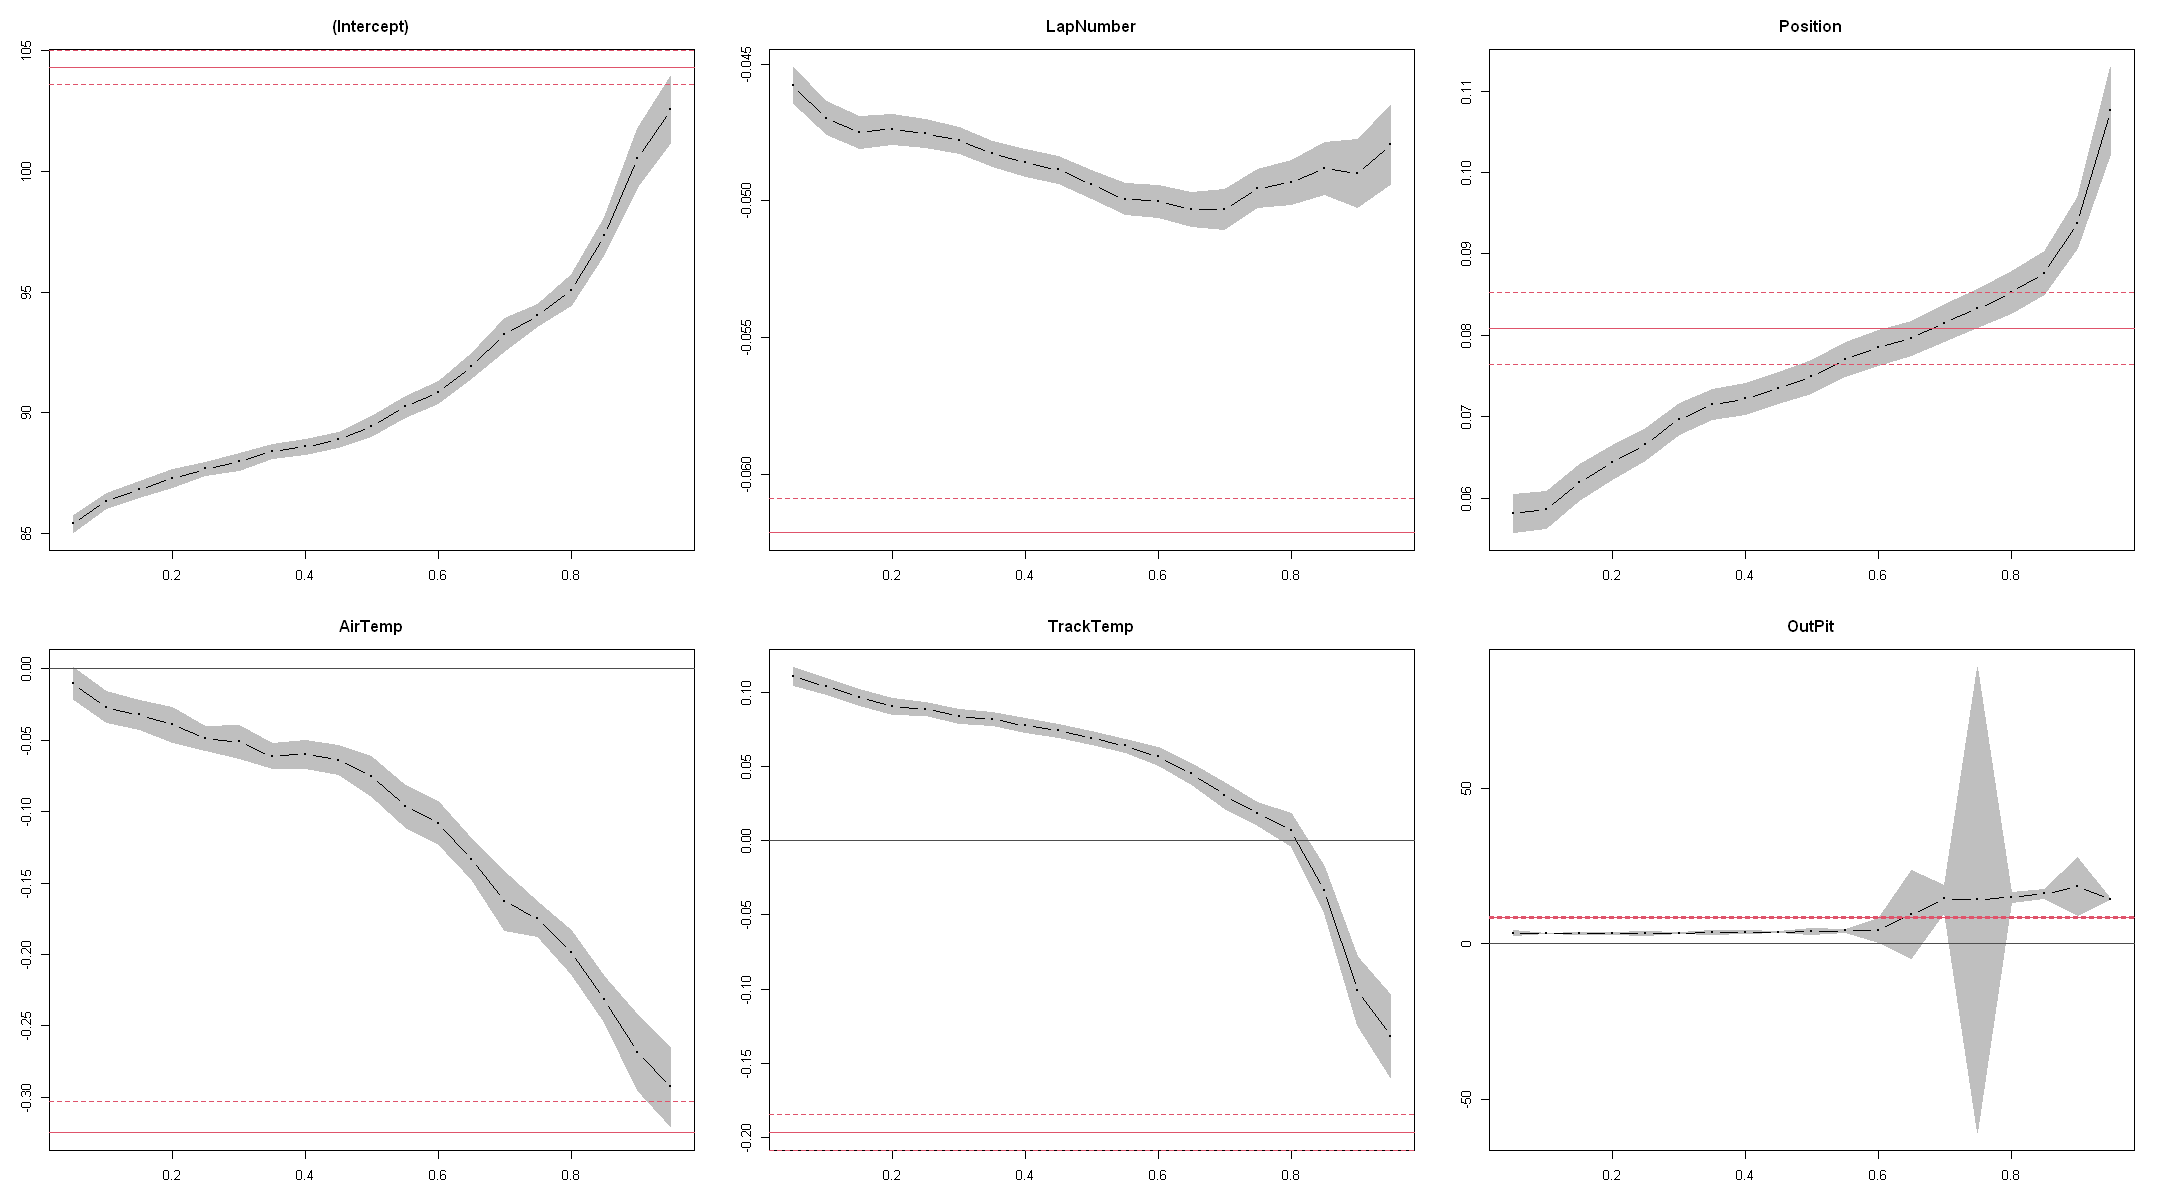

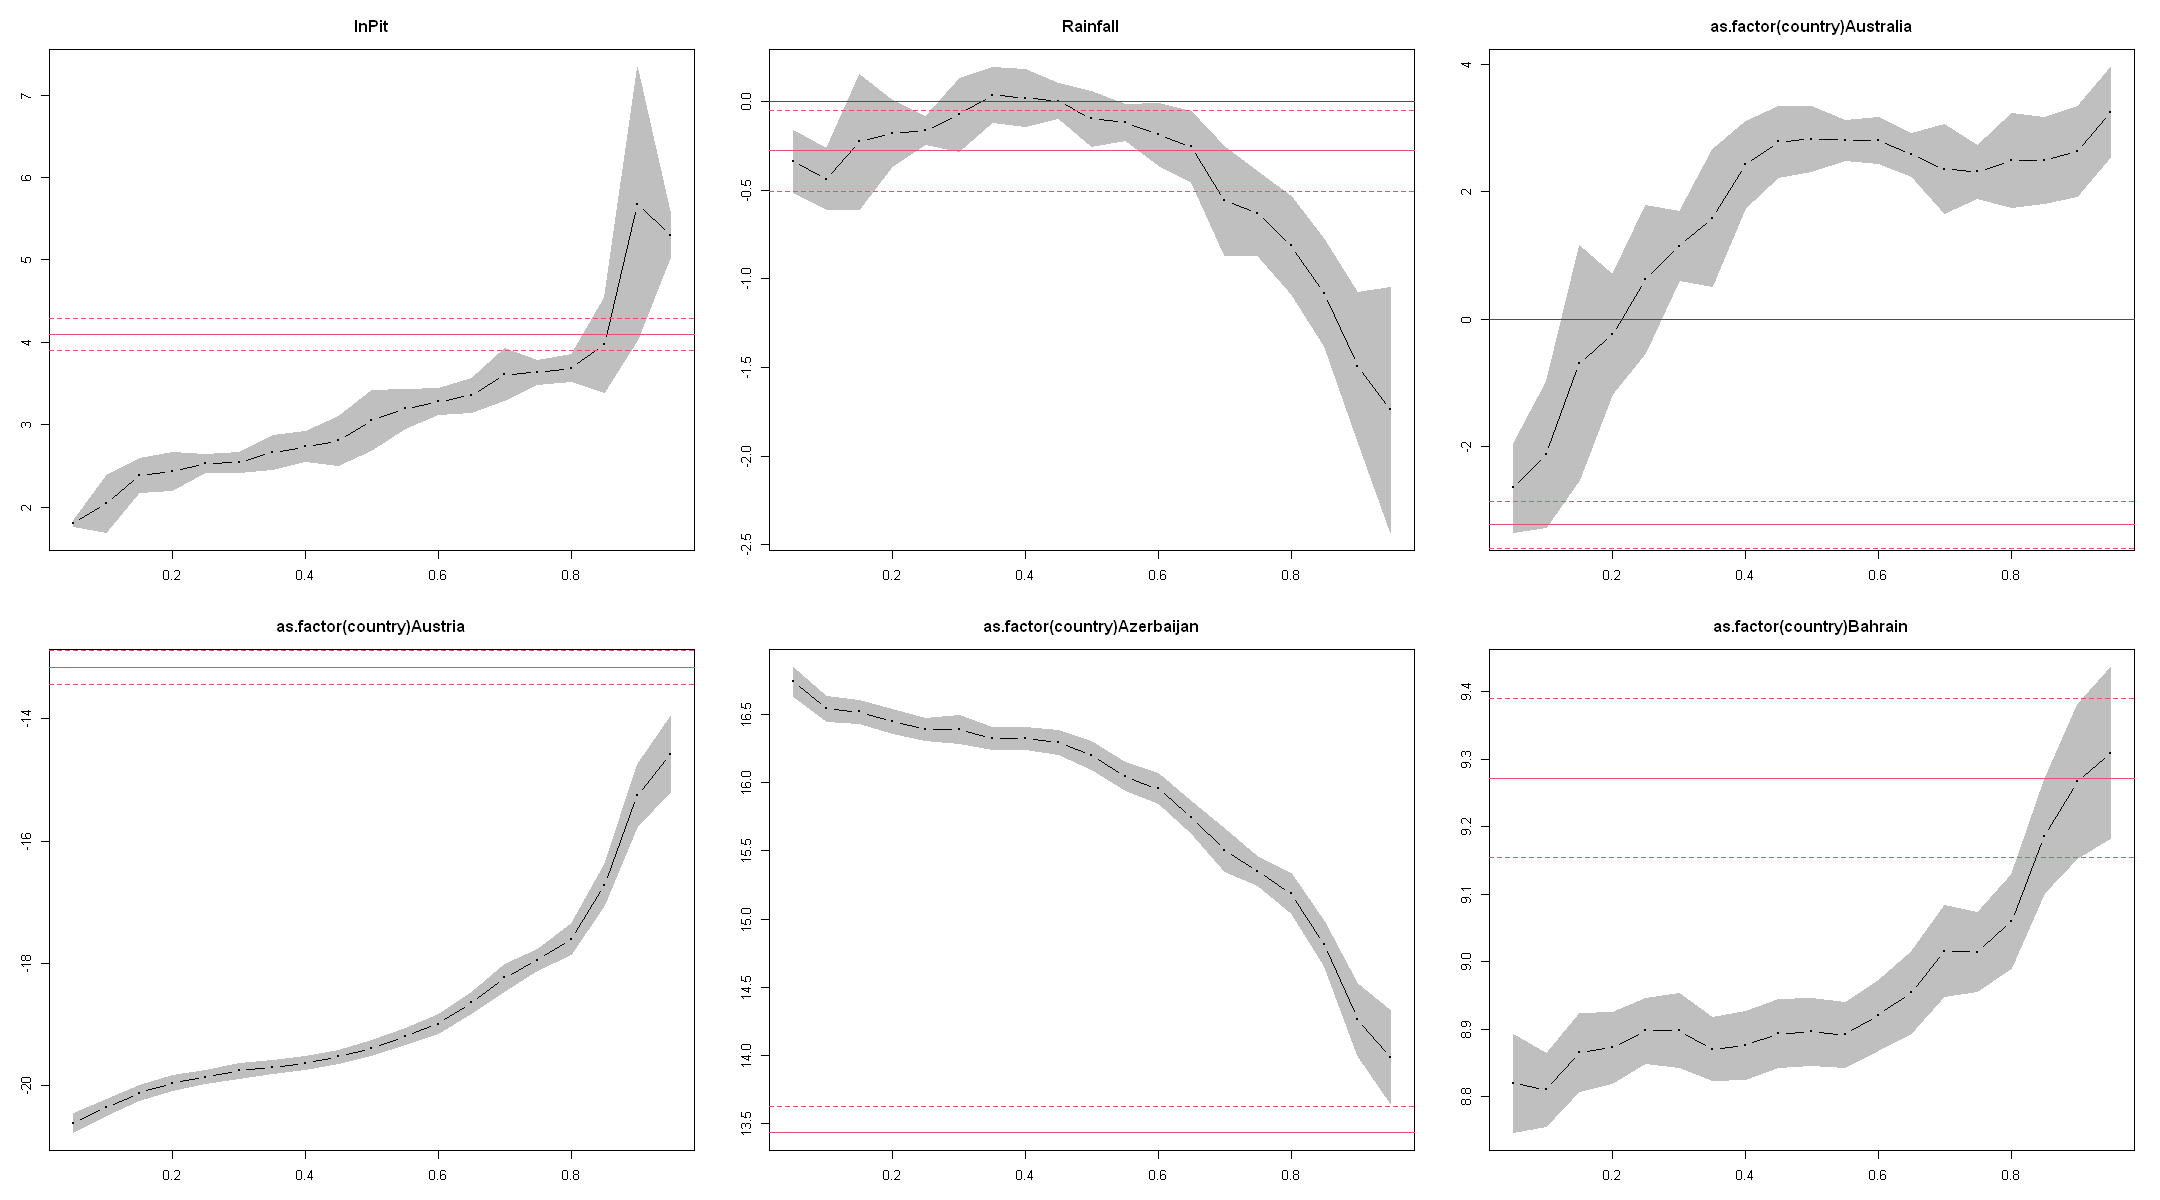

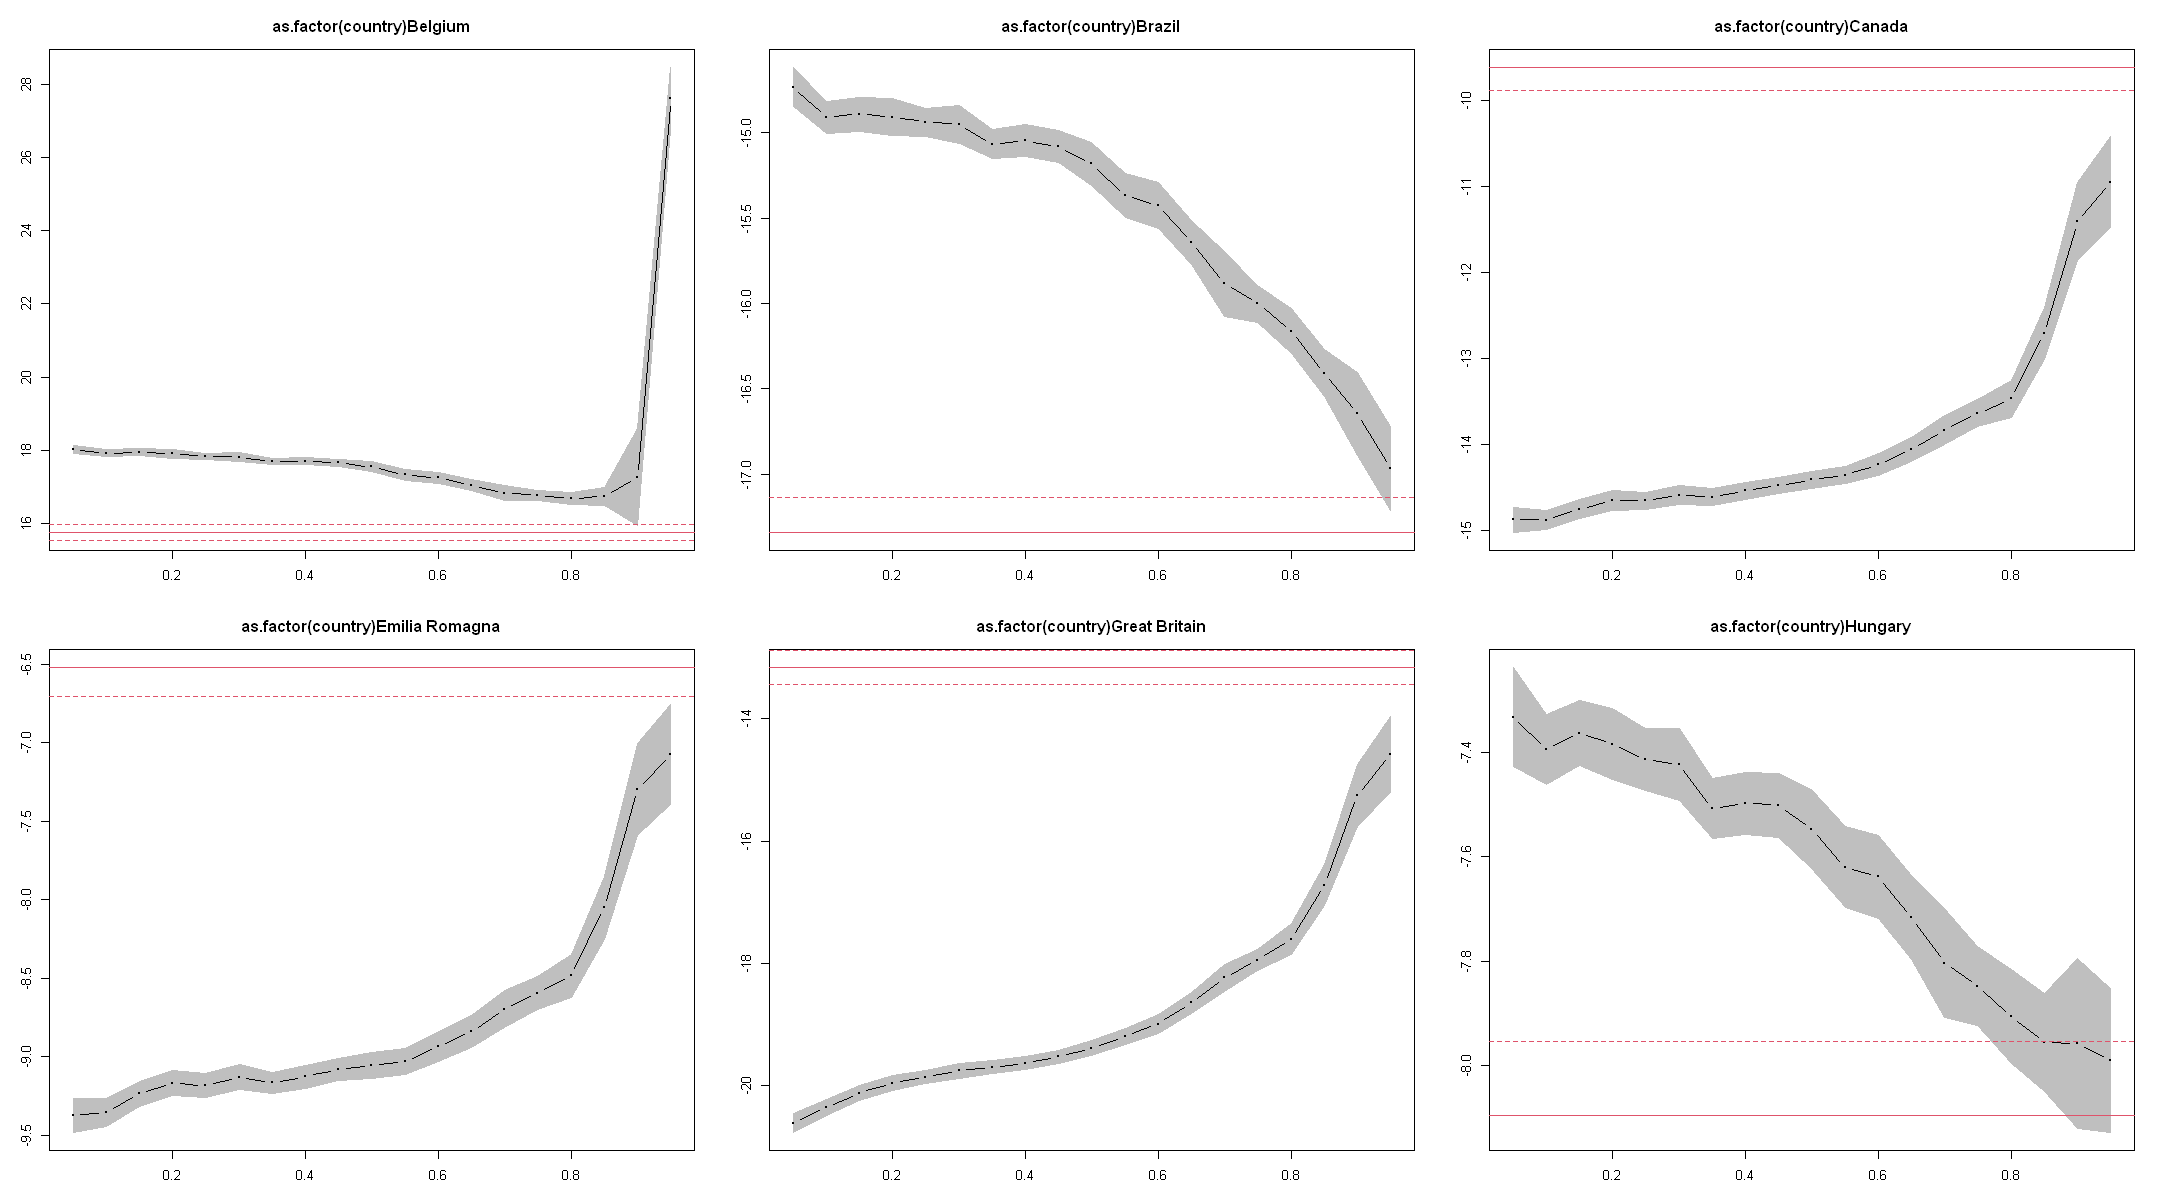

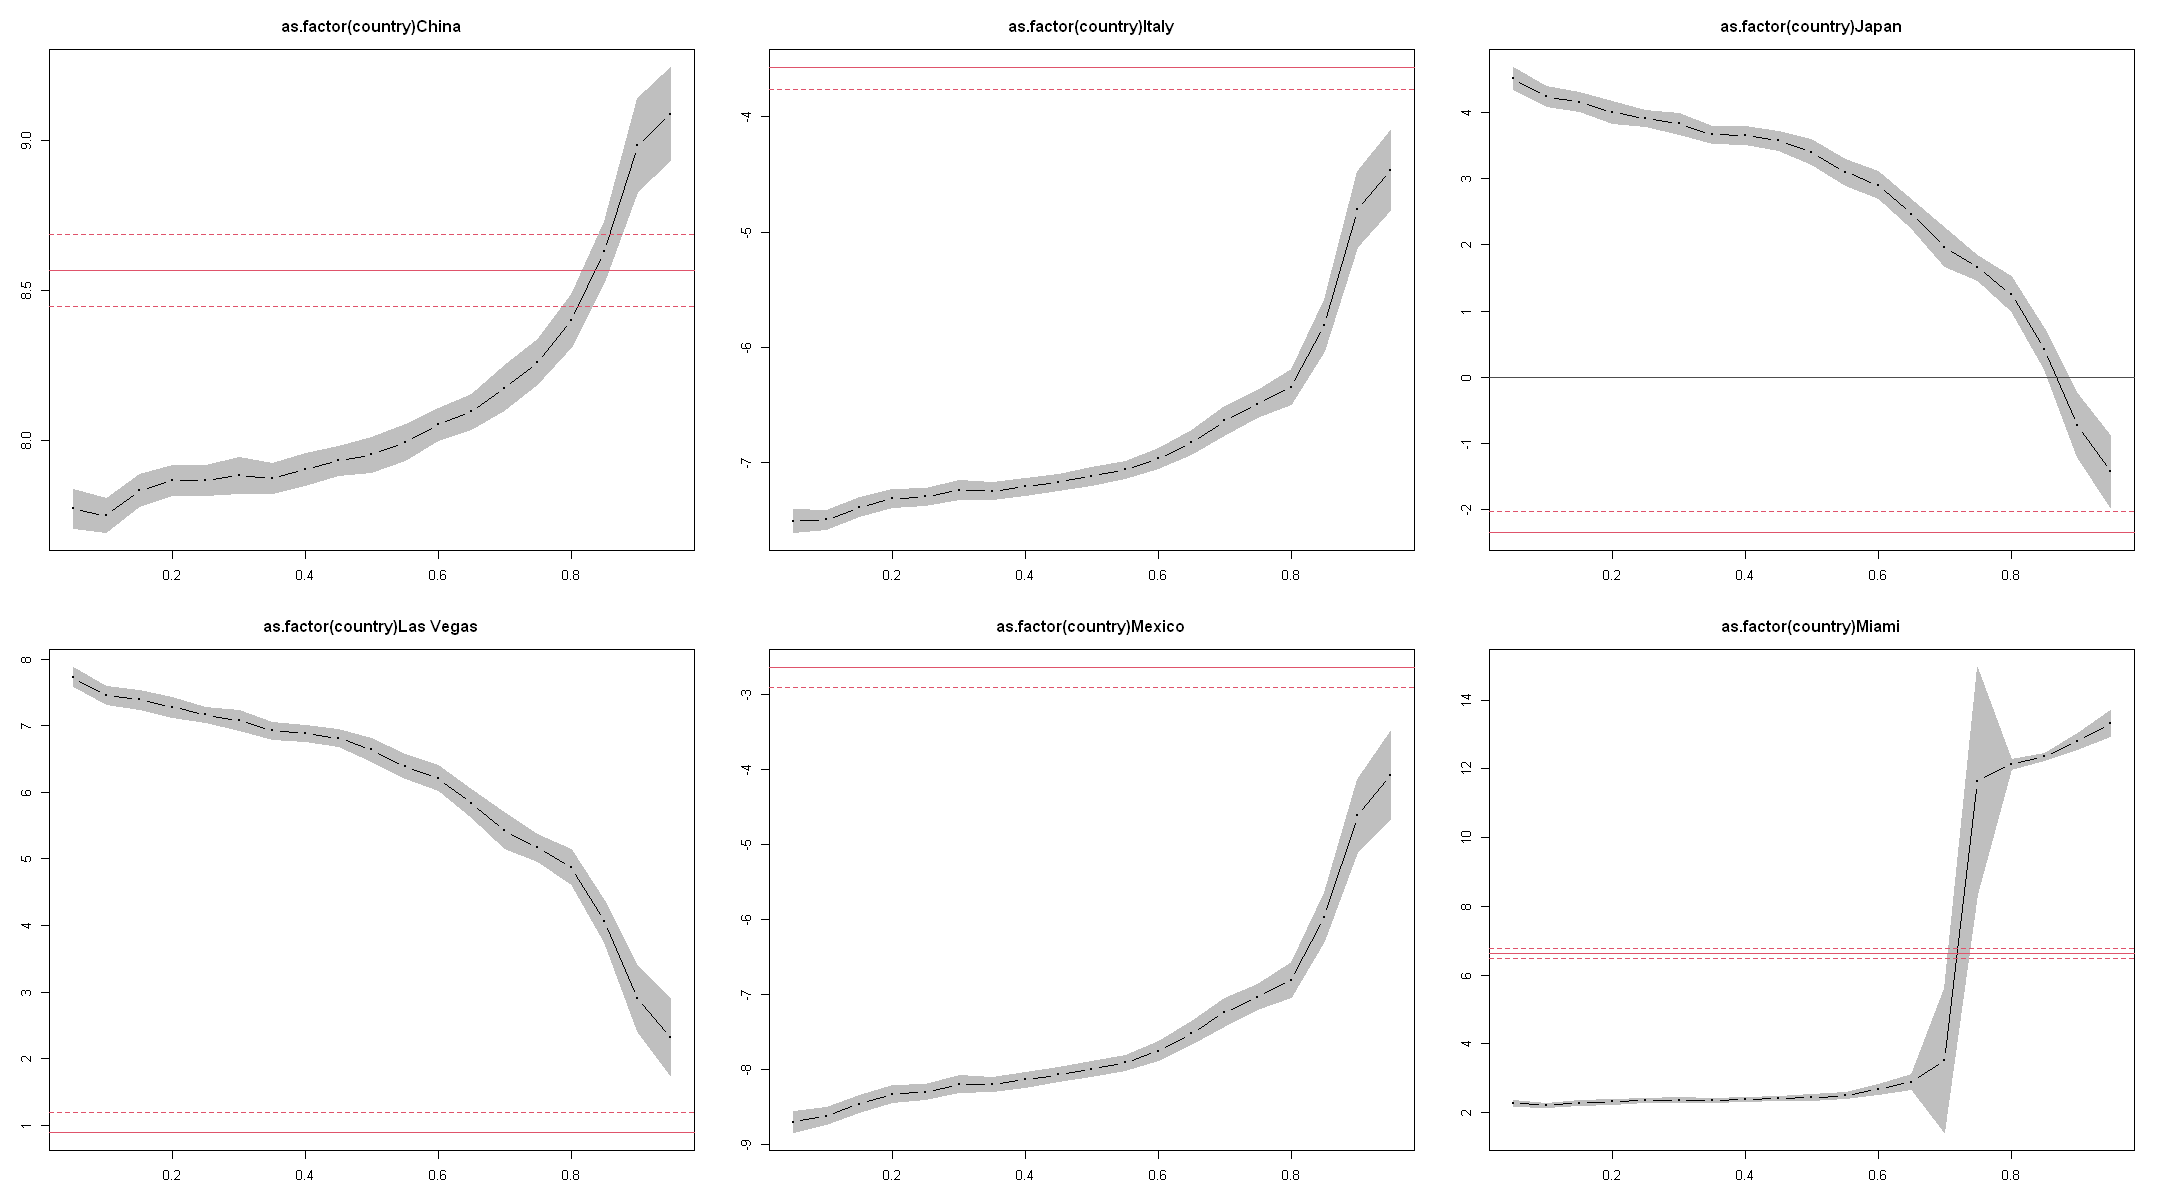

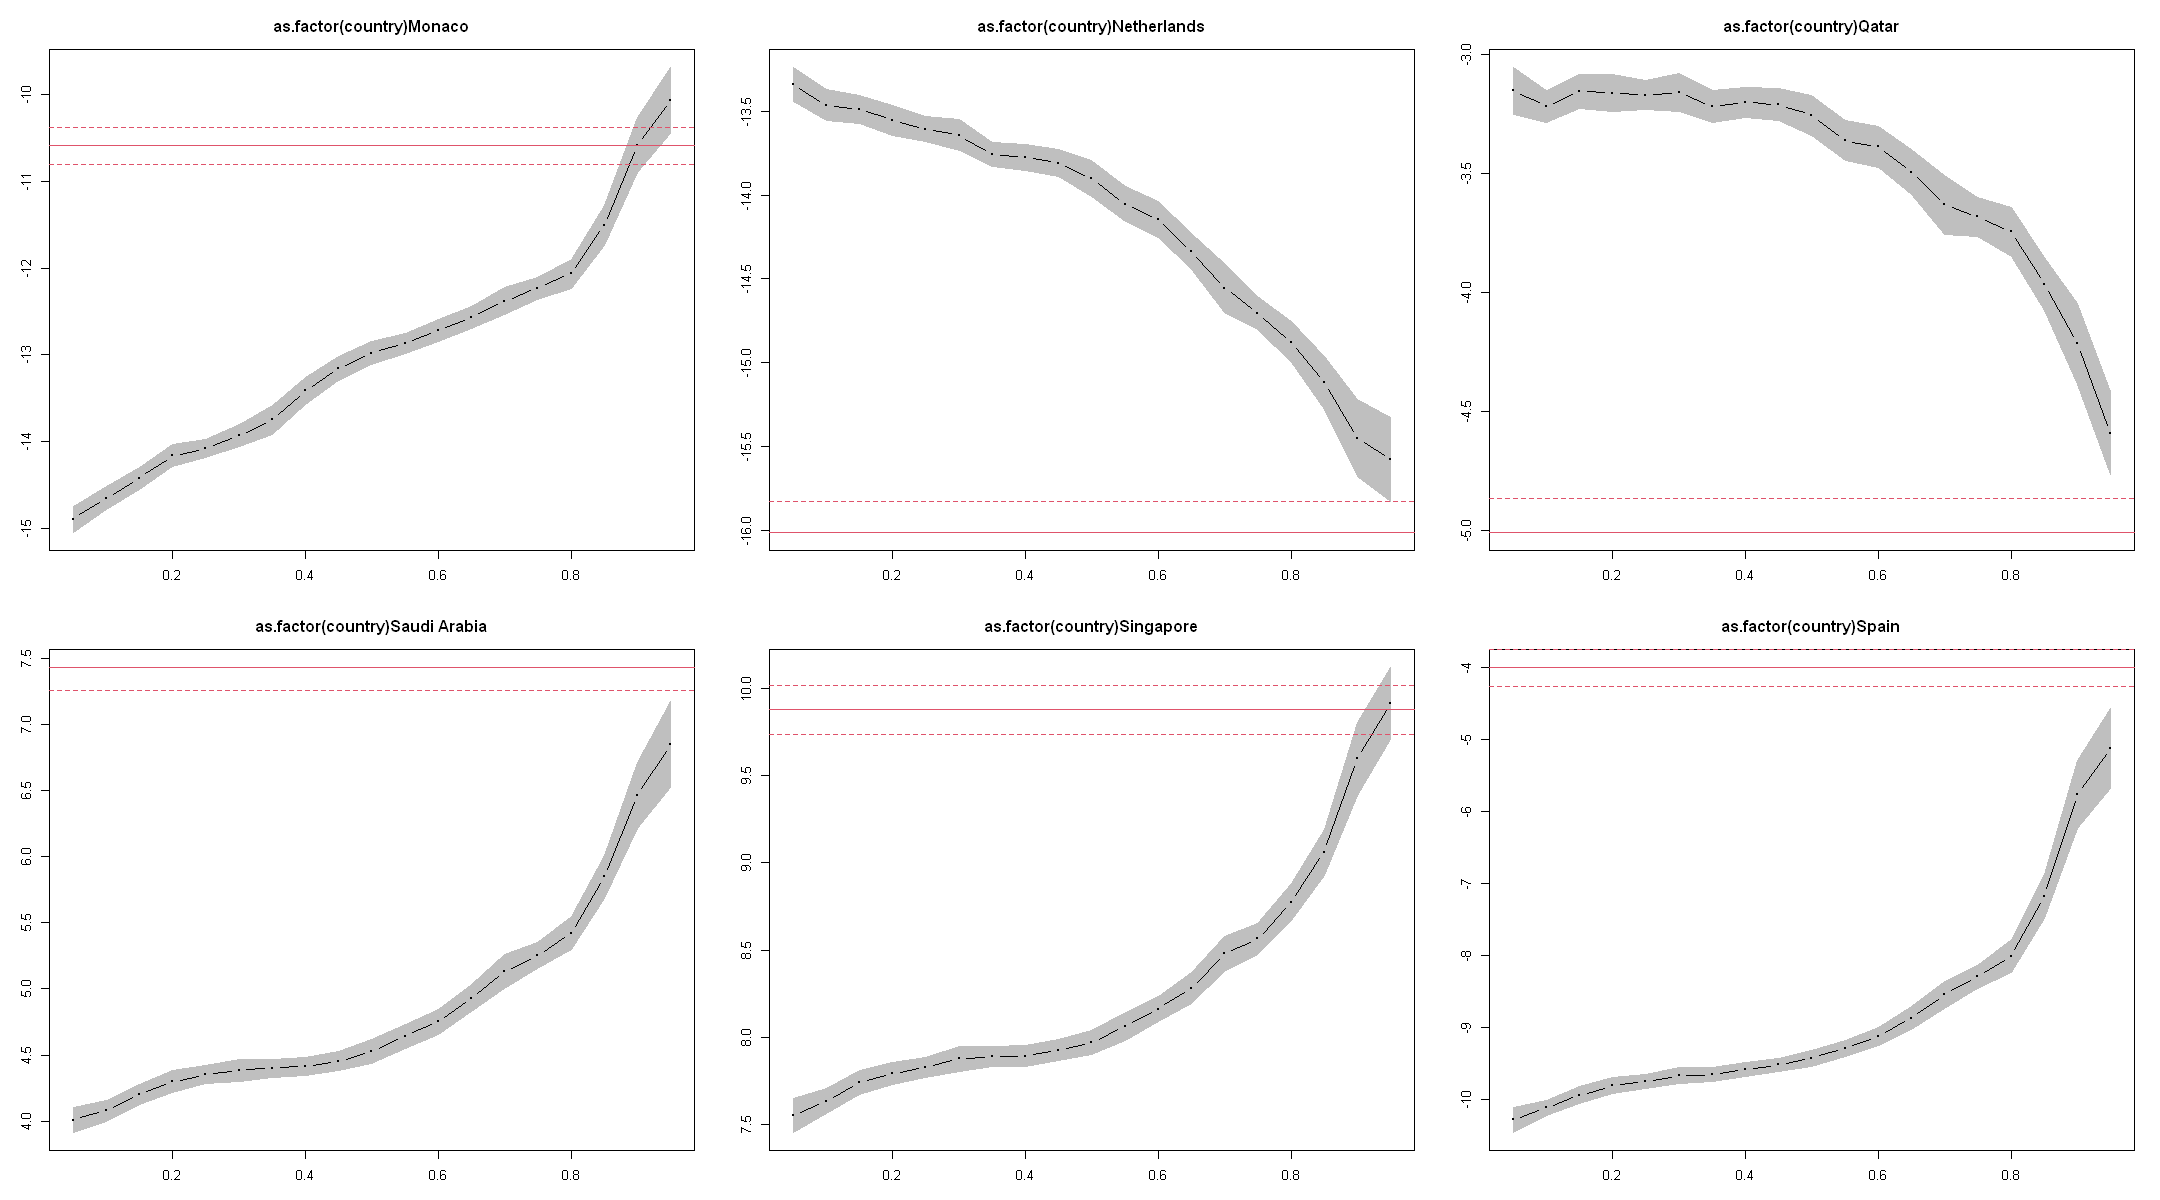

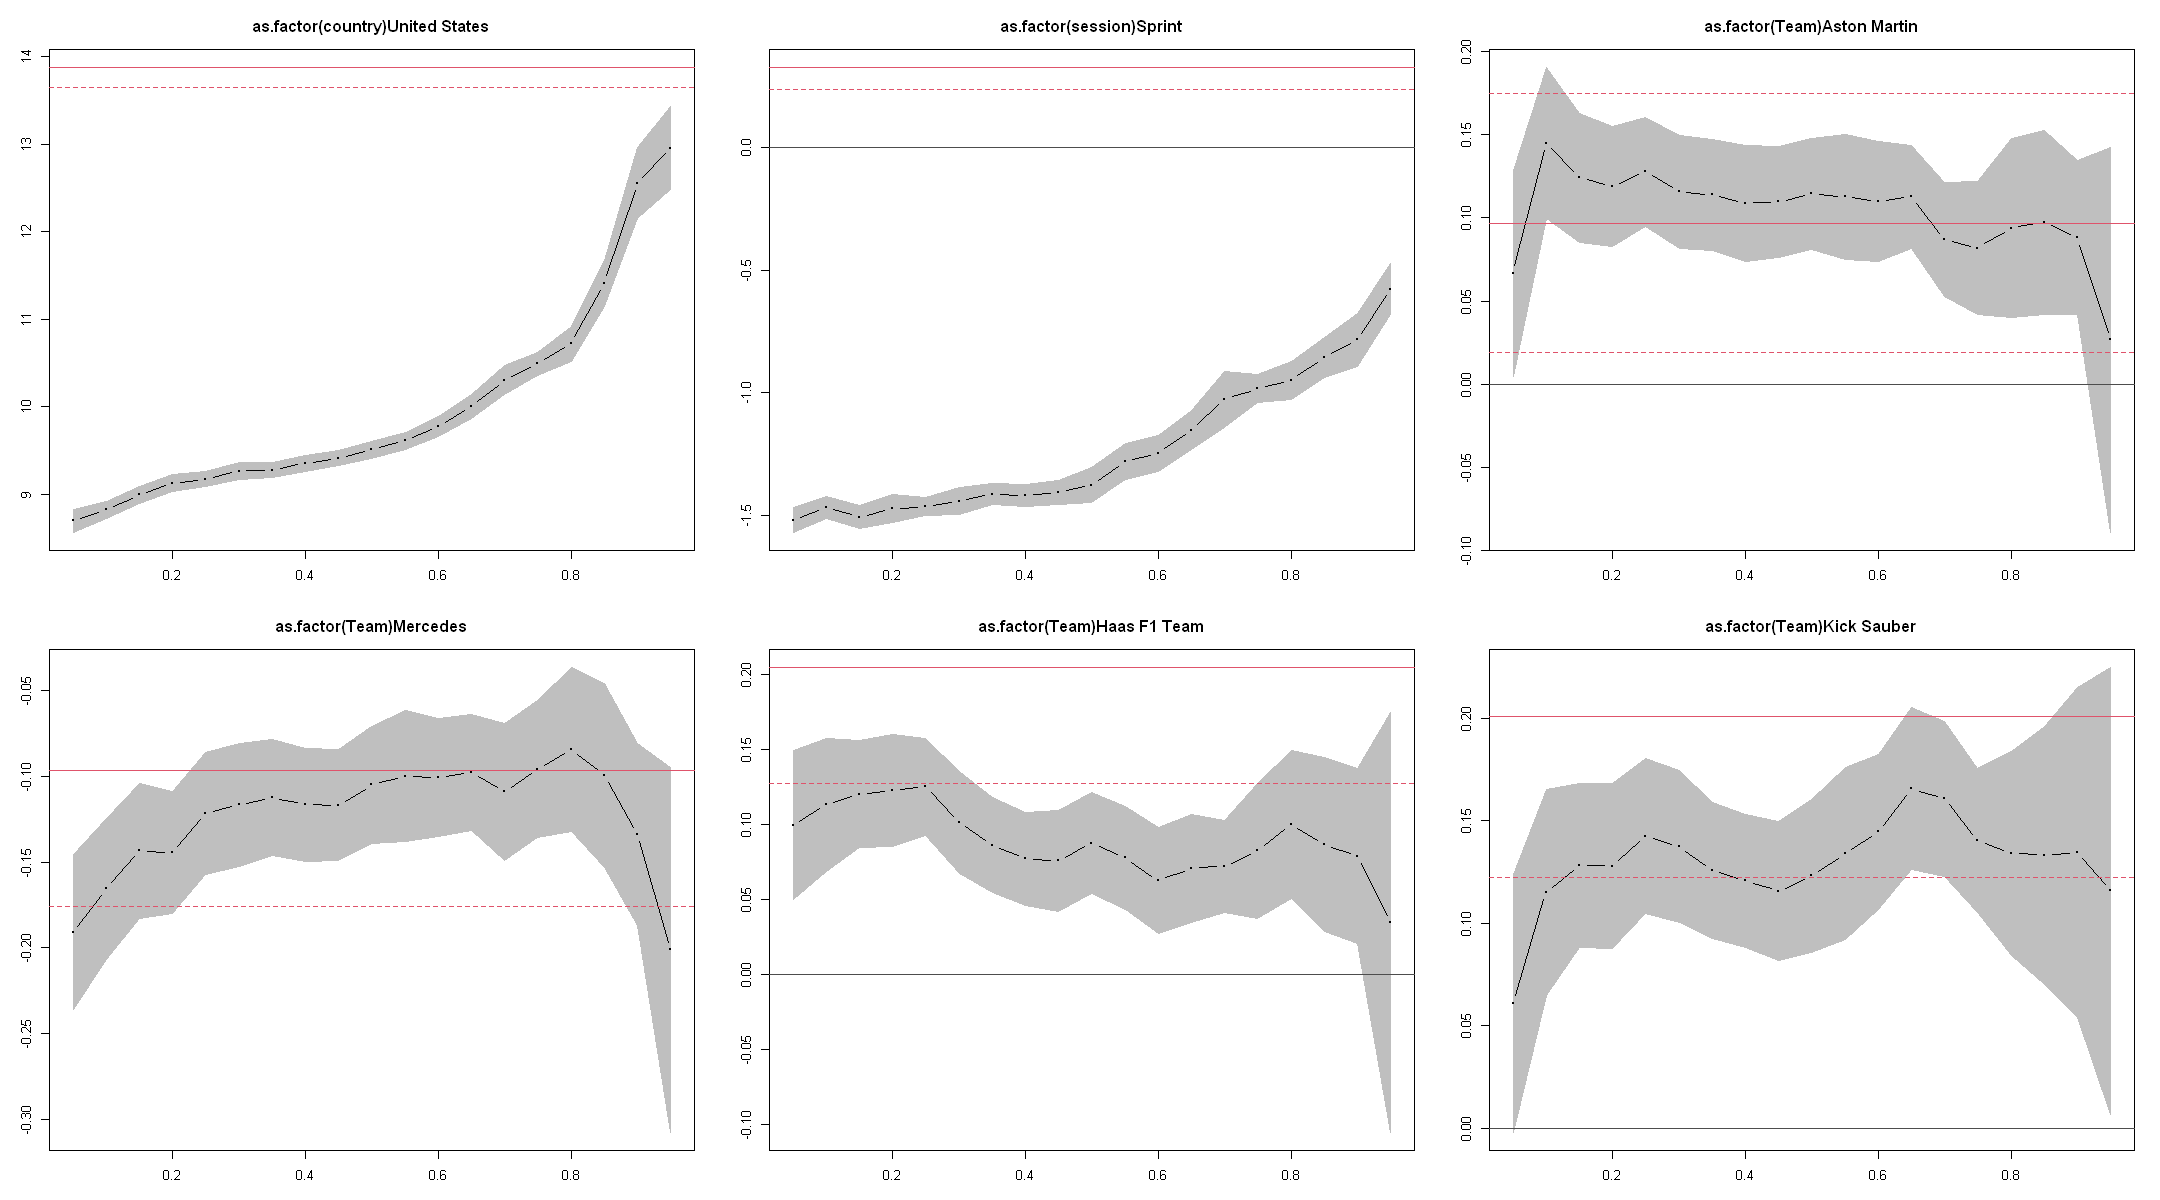

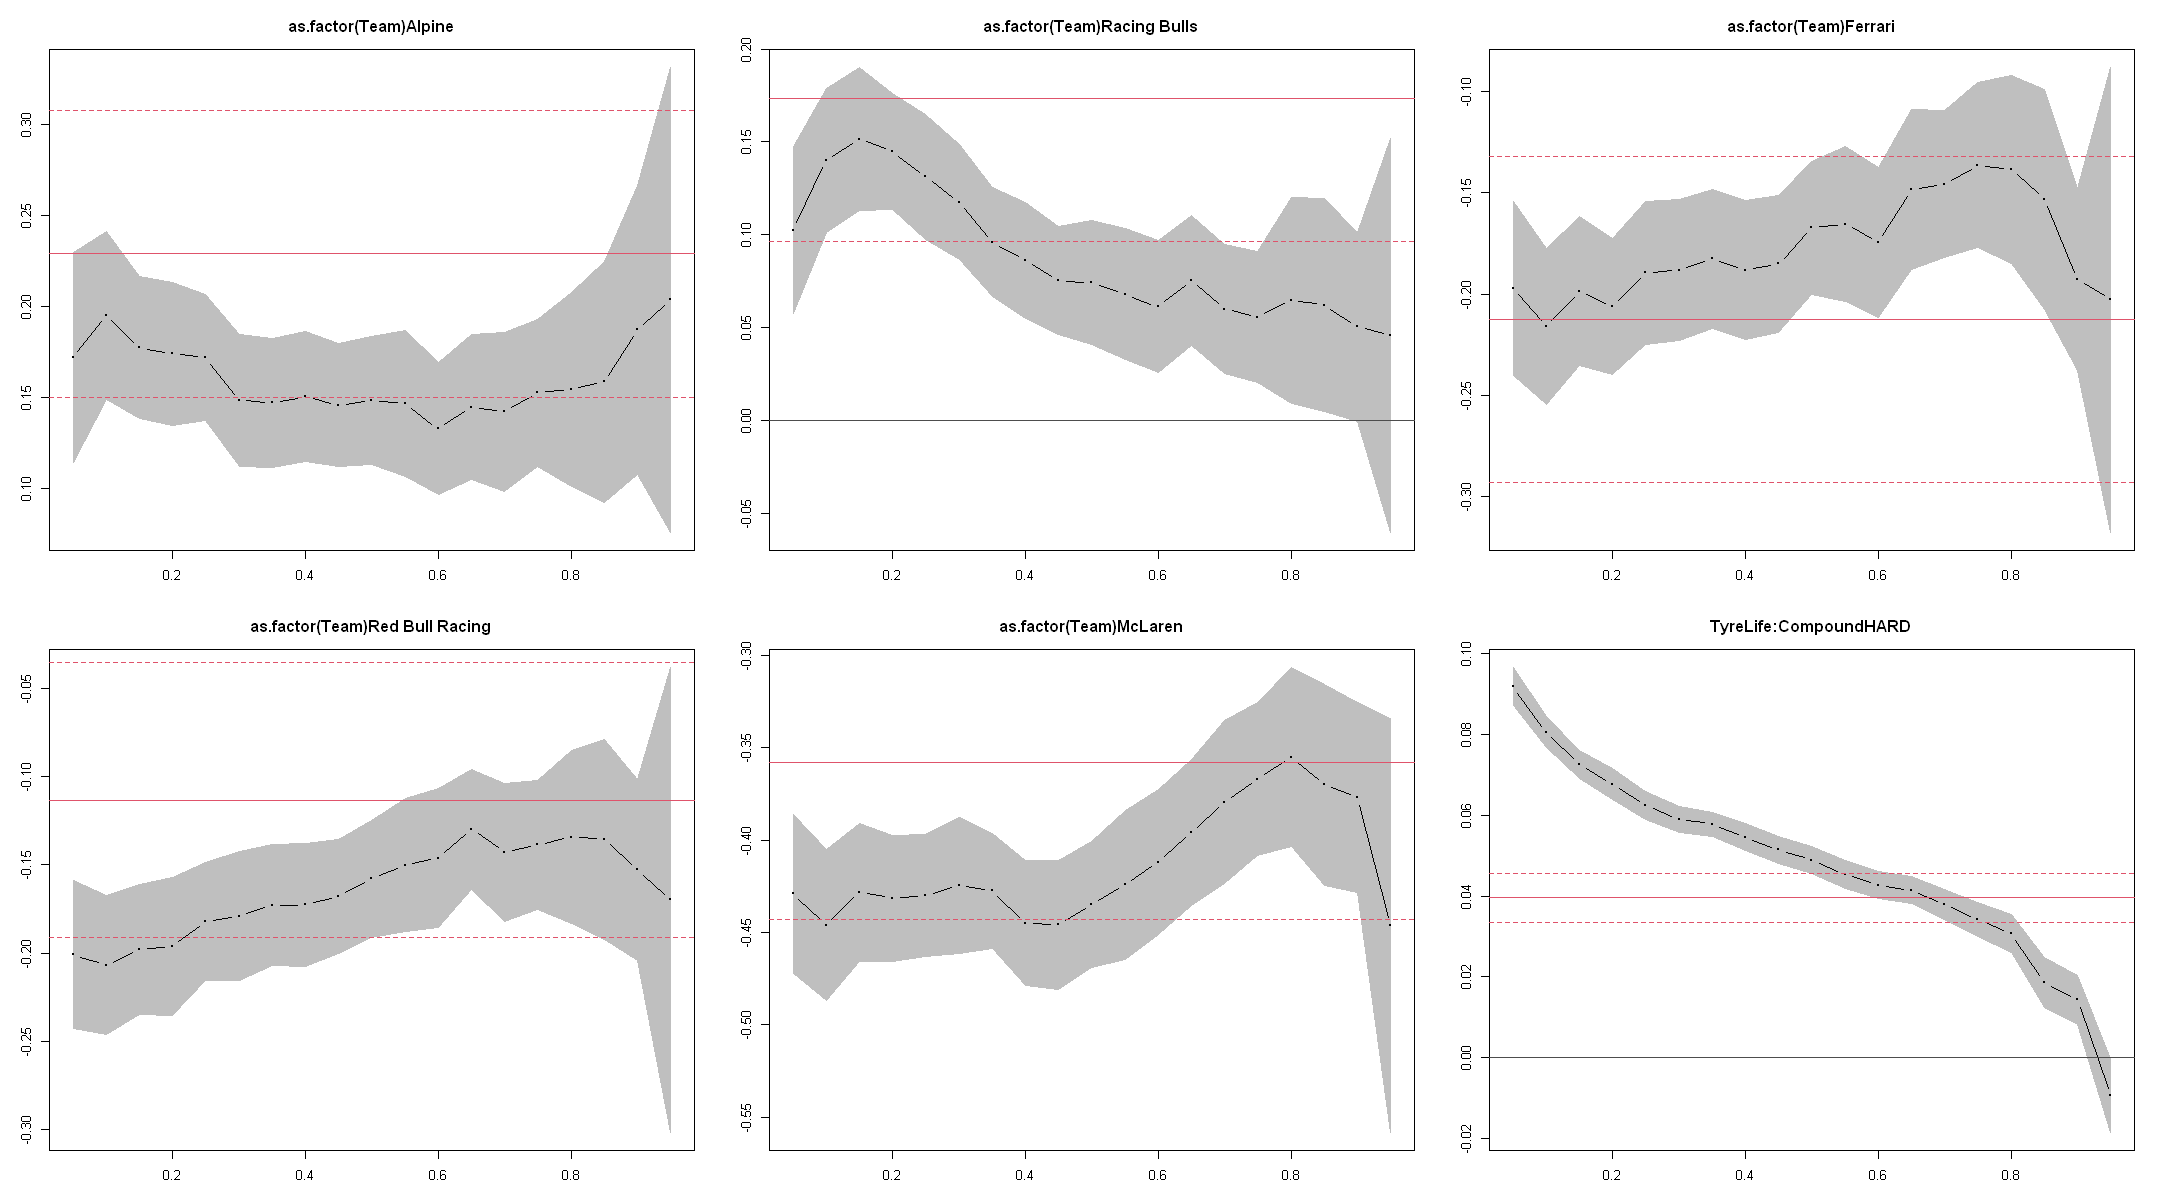

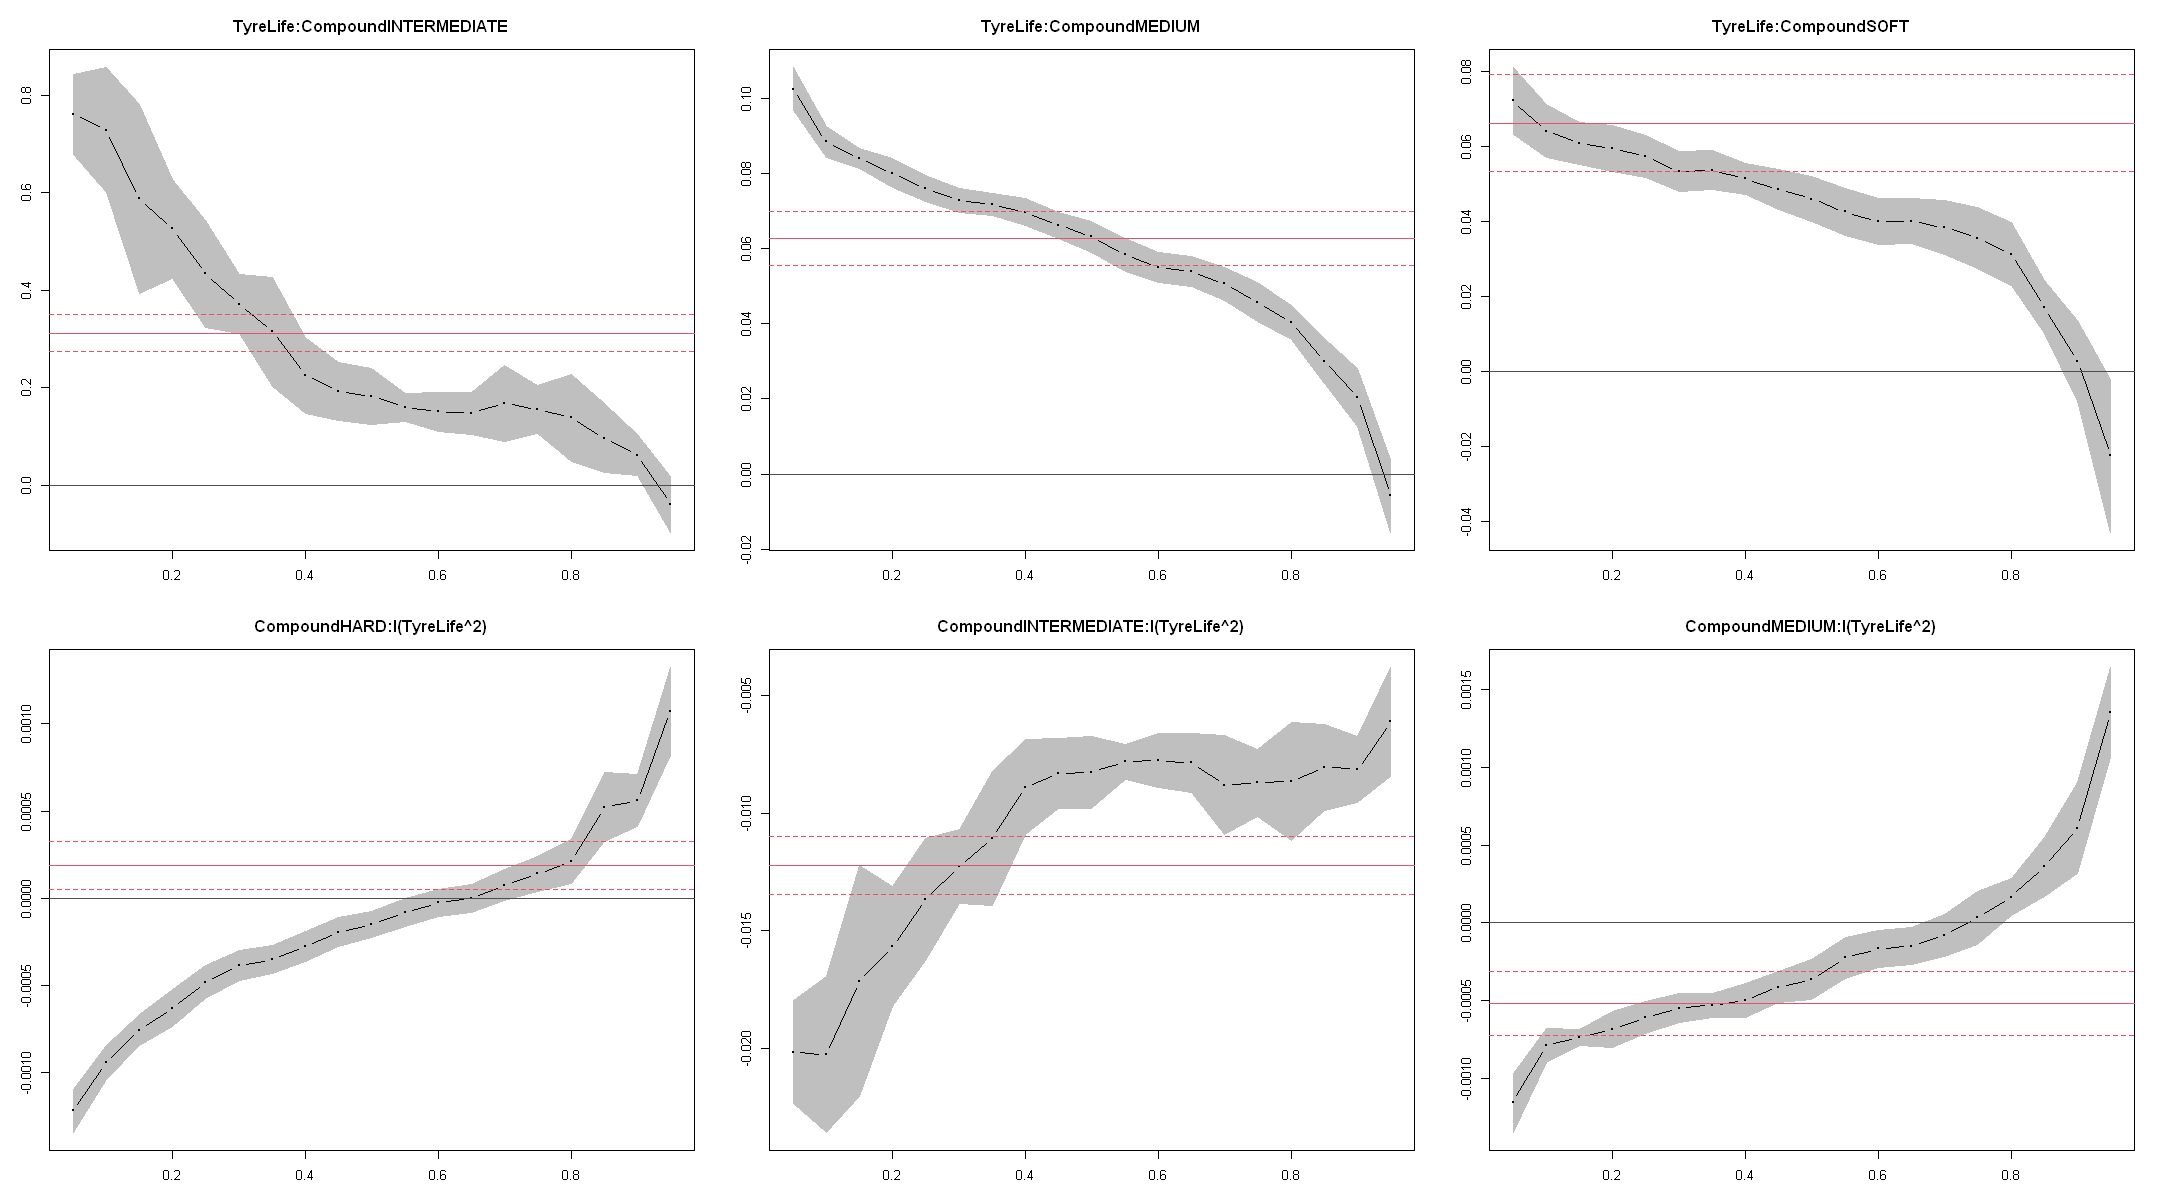

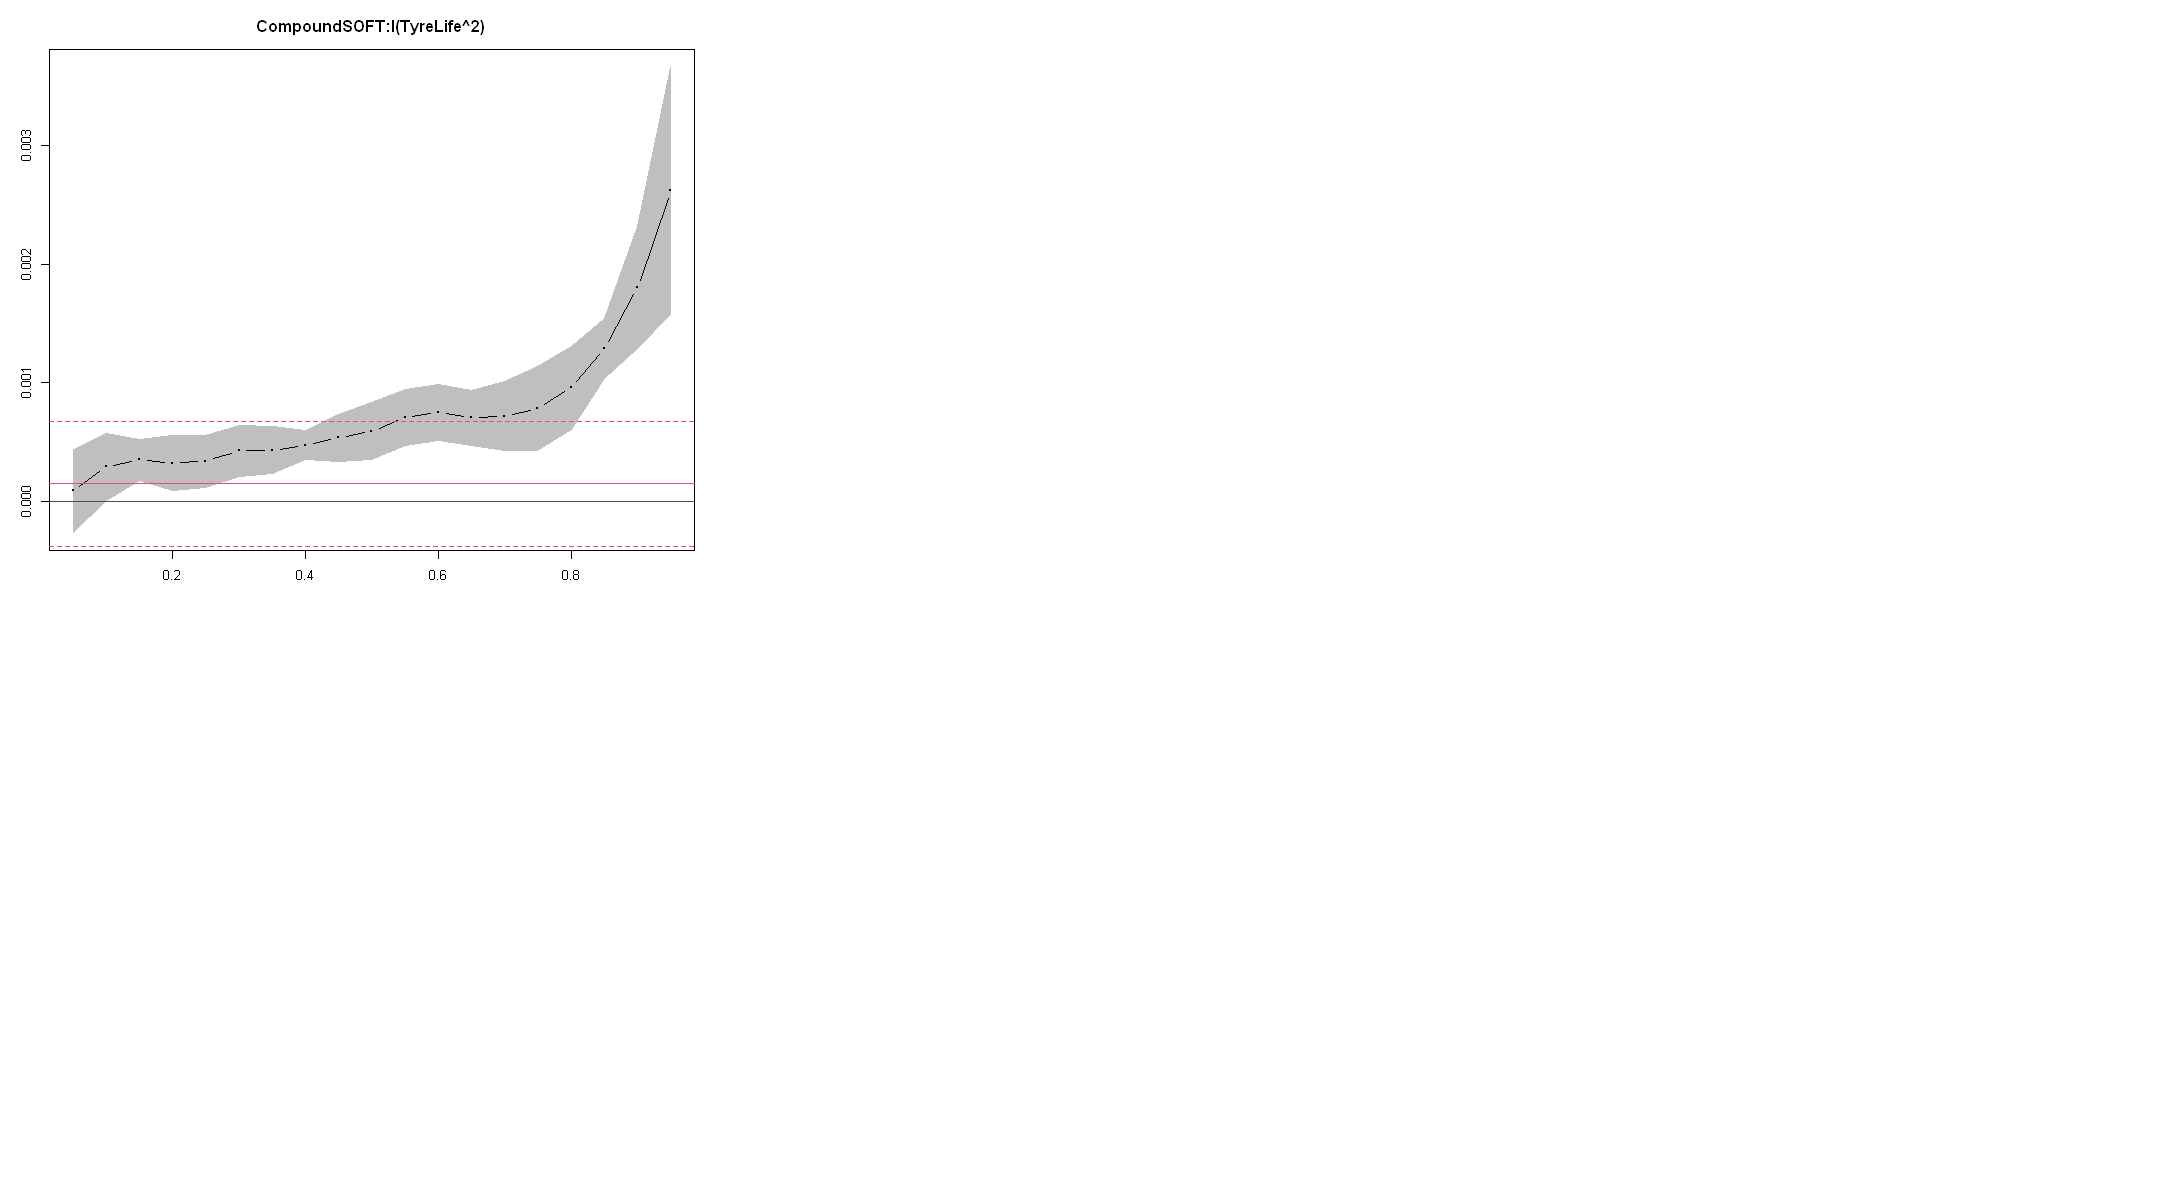

In [150]:
#print(quantile_regression) # see the coefficients, for more details have a look at sum_quant_reg
par(bg = "white")
options(repr.plot.width=18, repr.plot.height=10)
plot(sum_quant_reg, mfrow = c(2, 3))

In [152]:
pFtest(fe_model, pols)


	F test for individual effects

data:  panel_formula
F = 179.14, df1 = 14, df2 = 24209, p-value < 0.00000000000000022
alternative hypothesis: significant effects
